In [9]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from fitting_functions import *
import glob
from astropy.constants import c
from astropy.io import ascii
import astropy.units as u
from Borg_emission_lines import lines
import pickle
import random
import pprint
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

In [8]:
import os
os.chdir("C:/Downloads")

In [49]:
file_spec = 'spectra_13Dec2024_full.p'
with open(file_spec, 'rb') as file:
    data_spec = pickle.load(file)


tab = ascii.read('highz_msaid_public.dat')
merged_df = pd.read_csv('Test_Dataframe.csv')

ratio_lines = ['[OIII]_5007_flux_SNR', 'Hbeta_flux_SNR', '[NeIII]_flux_SNR', '[OII]_doublet_flux_SNR']

proc_df = pd.read_csv('processed_test_df.csv')

In [48]:
proc_df[[col for col in proc_df.columns if col.endswith('SNR')]]

,[OIII]_5007_flux_SNR,Hdelta_flux_SNR,[OII]_doublet_flux_SNR,CIV_doublet_flux_SNR,Hepsilon_flux_SNR,[NeIII]_flux_SNR,CIII]_doublet_flux_SNR,[OIII]_4959_flux_SNR,OIII]_doublet_flux_SNR,Hbeta_flux_SNR,Hgammma_OIII_flux_SNR,MgI_5174_flux_SNR
0,23.476095,17.142862,36.603026,0.481881,1.728721,21.865396,1.660801,11.179092,0.000000,13.988703,26.240046,0.000000
1,37.806892,1.498804,7.641952,0.000000,0.556644,1.732330,1.624442,13.906908,0.578183,7.024163,1.718196,0.000000
2,13.437435,0.214269,-0.009631,0.753318,-0.525537,0.000000,0.777109,6.741888,1.328525,3.395510,2.055716,0.000000
3,25.531141,0.776352,2.897777,0.000000,0.000000,0.926481,1.725690,6.723038,0.000000,2.931894,0.058947,1.151407
4,9.370153,0.772384,3.629132,2.054523,1.343700,0.000000,0.000000,6.365511,0.000000,0.396669,0.226377,0.797189
...,...,...,...,...,...,...,...,...,...,...,...,...
1359,4.678430,0.000000,-0.000000,-0.000000,0.858222,0.897768,0.543033,0.000000,1.288210,1.155946,0.558207,0.000000
1360,52.496727,5.170851,1.585567,1.255038,1.631020,4.521838,1.675106,17.035148,0.000000,11.980816,6.202396,NaN
1361,2.692454,0.000000,4.059621,0.983794,1.145367,5.386700,0.000000,13.043499,-1.124992,9.216620,1.738291,0.017480
1362,32.693387,0.000549,4.535049,0.604618,0.838674,1.712021,1.959885,12.960511,2.241961,4.053732,1.493865,0.050153


In [17]:
borg_ids = ['2426_112','2426_1736','2426_1130','2426_1777','2426_169','2426_1690','2426_1655','1747_199','1747_732','1747_902','1747_1081','1747_817','1747_1425','1747_138']

In [18]:
def get_spec_key(gal):
    PREFERRED_KEYS = [
        'prism-clear',
        'g140h-f100lp',
        'g140m-f100lp',
        'g140m-f070lp',
        'g235h-f170lp',
        'g235m-f170lp',
        'g395h-f290lp',
        'g395m-f290lp'
    ]
    keys = data_spec[gal].keys()
    for k in PREFERRED_KEYS:
        if k in keys:
            return k
    return None  

## Spectral Fitting Function (SNR Calculation, Unit Conversion and Try-Except Statements added)

In [ ]:
#This function mimics the provided Spectra Fitting code, but works on a particular set of galaxies individually, by Galaxy ID. Also allows for a custom SNR 

def find_spectral_features(gal_ids, num_bootstraps):
    all_snr_values = []
    # Collect Base SNR in the data set. 
    all_fit_results = []
    for idx, gal in enumerate(gal_ids):
        try:
            spec_key = get_spec_key(gal)
            if spec_key is None:
                print(f"Skipping {gal}: no supported instrument found")
                continue
            itab = np.where(tab['msaid'] == gal)[0]
            z = tab['z'][itab][0]
            wavelength = data_spec[gal][spec_key]['lam']*1e4
            flux_nu = data_spec[gal][spec_key]['flux']
            flux_nu_err = data_spec[gal][spec_key]['err']

            flux_l = convert_fnu_to_flambda(wavelength, flux_nu) * 1.e20
            flux_l_err = convert_fnu_to_flambda(wavelength, flux_nu_err) * 1.e20
            


            # select indices in wavelength array that correspond to our selected wavelength range
            redshift_lines = {key: value * (z + 1) for key, value in lines.items()}
            spectral_windows = {
                'CIV_window': [redshift_lines['CIV_doublet'] - 1500, redshift_lines['CIII]_doublet'] + 1500],
                'OII_window': [redshift_lines['[OII]_doublet'] - 1500, redshift_lines['Hgammma_OIII'] + 1500],
                'Hb_OIII_window': [redshift_lines['Hbeta'] - 1500, redshift_lines['[OIII]_5007'] + 1500]
            }

            # Begin bootstrap sampling:
            N = num_bootstraps
            bootstrap_results = {
                'continuum_slope': [],
                'continuum_intercept': [],
                'line_fluxes': [],  # List of dictionaries, one per iteration
                'flux_ratios': [],  # List of dictionaries, one per iteration
                'amplitudes': [],   # Add amplitudes to the dictionary
                'widths': []        # Add widths to the dictionary
            }   

            
            # **Compute Errors from Bootstrap Samples**
            final_results = {}  # Reset for each galaxy!
            count=0
            for _ in range(N):  # loop over the noise and then get the windows, and at every iteration compute the line fluxes and ratios
                count+=1
                # Generate new spectrum by adding Gaussian noise
                flux_new = flux_l + np.random.normal(0, flux_l_err)

                # Dictionary to store this iteration's line fluxes
                iteration_fluxes = {}
                iteration_ratios = {}
                iteration_amplitudes = {}
                iteration_widths = {}

                for window_name, window_range in spectral_windows.items():
                    sliced_index = np.where((wavelength >= window_range[0]) & (wavelength <= window_range[1]))
                    window_wavelength = wavelength[sliced_index]
                    window_flux = flux_l[sliced_index]
                    window_flux_err = flux_l_err[sliced_index]
                    invalid_spec = np.where((np.isfinite(window_flux) == False) | (np.isfinite(window_flux_err) == False))
                    window_flux[invalid_spec] = 0.
                    window_flux_err[invalid_spec] = 1.e20
            
                    model = models.Polynomial1D(1)
                    Nlines = 0

                    for key in redshift_lines:
                        lam = redshift_lines[key]
                        if (lam < np.nanmin(window_wavelength)) | (lam > np.nanmax(window_wavelength)):
                            continue

                        line = models.Gaussian1D(amplitude=np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))]),
                                                mean=lam, stddev=60)
                        line.amplitude.min = 0.  # 1.e-3
                        line.amplitude.max = np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))])
                        line.amplitude.fixed = False
                        line.stddev.min = 0.  # 1.e-3
                        line.stddev.fixed = False
                        model += line
                        Nlines += 1

                    # Fit model:
                    fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True)
                    g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)
                    # Check fit status using fit_info
                    status = fit_g.fit_info.get('status')

                
                    # Store bootstrapped parameters for this iteration
                    bootstrap_results['continuum_slope'].append(g.parameters[0])  # Use g.parameters[0] for the slope (c0)
                    bootstrap_results['continuum_intercept'].append(g.parameters[1])  # Use g.parameters[1] for the intercept (c1)


                    #for line_name, lam in redshift_lines.items():
                    for i, line_name in enumerate([key for key in redshift_lines if redshift_lines[key] >= np.nanmin(window_wavelength) and redshift_lines[key] <= np.nanmax(window_wavelength)]):

                        #print(line_name)
                        amp = getattr(g, f'amplitude_{i+1}').value
                        width = getattr(g, f'stddev_{i+1}').value

                        # Store in dictionaries for later error calculation
                        if line_name not in iteration_amplitudes:
                            iteration_amplitudes[line_name] = []
                            iteration_widths[line_name] = []

                        iteration_amplitudes[line_name].append(amp)
                        iteration_widths[line_name].append(width)

                        # **Compute line flux**
                        flux = amp * width * np.sqrt(2 * np.pi) * 1.e-2
                        iteration_fluxes[f"{line_name}_flux"] = flux
                    # print(count) #correctly goes throush the 3 spectral windows and finds fluxes for all lines, this for 100 times


                # **Compute flux ratios**
                # print(iteration_fluxes) #Fluxes saved correctly! No overwritting
                if '[NeIII]_flux' in iteration_fluxes and '[OII]_doublet_flux' in iteration_fluxes:
                    iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']

                if '[OIII]_5007_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                    iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']

                if 'Hdelta_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                    iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']

                if 'Hgammma_OIII_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                    iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']



                # Debugging: Print ratios for each iteration
                #print(f"Iteration {count} flux ratios: {iteration_ratios}") This worked!

                # Store this bootstrap iteration's results
                bootstrap_results['line_fluxes'].append(iteration_fluxes)
                bootstrap_results['flux_ratios'].append(iteration_ratios)
                bootstrap_results['amplitudes'].append(iteration_amplitudes)
                bootstrap_results['widths'].append(iteration_widths)

            # Now that all bootstrap iterations are done, plot and save the fit for each spectral window
            for window_name, window_range in spectral_windows.items():
                sliced_index = np.where((wavelength >= window_range[0]) & (wavelength <= window_range[1]))
                window_wavelength = wavelength[sliced_index]
                window_flux = flux_l[sliced_index]
                window_flux_err = flux_l_err[sliced_index]

                # Define the model and fit it
                model = models.Polynomial1D(1)
                Nlines = 0

                for key in redshift_lines:
                    lam = redshift_lines[key]
                    if (lam < np.nanmin(window_wavelength)) | (lam > np.nanmax(window_wavelength)):
                        continue

                    line = models.Gaussian1D(
                        amplitude=np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))]),
                        mean=lam, stddev=60
                    )
                    line.amplitude.min = 0.
                    line.amplitude.max = np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))])
                    model += line
                    Nlines += 1

                # Fit the model to the spectrum
                fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True)
                g = fit_g(model, window_wavelength, window_flux, weights=1 / window_flux_err, maxiter=10000, estimate_jacobian=True)

                #############################################################################################################
                #Add Fit Diagnostics (Metric to see which galaxies fit poorly) 
                #Compute RMSE of residual, coming from subtracting observed flux in specific wavelength from the
                #fit function to the data in that same wavelength window 
                residuals = window_flux - g(window_wavelength)
                
                rms = np.sqrt(np.mean(residuals**2)) 
                print(f"RMS for {gal} in {window_name}: {rms:.4g}")
                final_results[f"{window_name}_fit_rms"] = rms
                
                
                #############################################################################################################
                # Plot and save the fit for each spectral window
                fig = plt.figure(figsize=(7, 7))
                plt.title(gal + " - " + window_name, fontsize=16)
                plt.step(window_wavelength, window_flux, where='mid', color='k', label='Data')  # Original data
                plt.step(window_wavelength, window_flux_err, where='mid', color='grey', linestyle='dotted', label='Error')  # Error bars
                residuals = window_flux - g(window_wavelength)  # Residuals
                plt.step(window_wavelength, residuals, where='mid', color='orange', label='Residuals')  # Residuals
                plt.plot(window_wavelength, g(window_wavelength), color='red', label='Fit')  # Model fit

                plt.xlabel(r"Wavelength ($\AA$)", fontsize=18)
                plt.ylabel(r"Flux (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)", fontsize=18)
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)

                # Save the plot as a PNG (or any other format)
                plot_filename = f"Figures_spectra/fit_{gal}_{window_name}.png"
                plt.savefig(plot_filename)  # Save the figure with a unique filename based on the window name

                plt.close()  # Close the plot after saving

            # **Find all emission lines across bootstraps**
            all_detected_lines = set()
            for iteration in bootstrap_results['line_fluxes']:
                all_detected_lines.update(iteration.keys())  # Collect all line_flux keys

            # **Compute errors for all detected lines**
            for line in all_detected_lines:
                flux_values = [iteration[line] for iteration in bootstrap_results['line_fluxes'] if line in iteration]
                if len(flux_values) > 0:  # Ensure at least one detection
                    flux_16, flux_median, flux_84 = np.percentile(flux_values, [16, 50, 84])
                    final_results[line] = flux_median
                    final_results[f"{line}_err"] = np.array([flux_median - flux_16, flux_84 - flux_median])  # Asymmetric errors
                    err_minus = flux_median - flux_16
                    err_plus = flux_84 - flux_median 
                    avg_error = (err_minus + err_plus) / 2 #Gives STD. 
                    line_SNR = flux_median / avg_error if avg_error > 0 else 0 #Avoid divisions by 0
                    final_results[f"{line}_SNR"] = line_SNR #Store SNR Values
                    
            #SNR Checking       
        
            # **Compute errors for flux ratios**
            for ratio in ['NeIII_OII_ratio', 'OIII5007_Hbeta_ratio','Hdelta_Hbeta_ratio','Hgamma_Hbeta_ratio']:
                ratio_values = [iteration[ratio] for iteration in bootstrap_results['flux_ratios'] if ratio in iteration]
                if len(ratio_values) > 0:
                    ratio_16, ratio_median, ratio_84 = np.percentile(ratio_values, [16, 50, 84])
                    final_results[ratio] = ratio_median
                    final_results[f"{ratio}_err"] = np.array([ratio_median - ratio_16, ratio_84 - ratio_median])                      

            # Append results **per galaxy**
            all_fit_results.append({gal: final_results})
            print(f"Final results for {gal}:", final_results.keys())
        except Exception as e: 
            print(f"Failed on {gal} due to: {e}")
    print(f"Processed {len(all_fit_results)} galaxies")
    return(all_fit_results)
                                   
    
                          
                          


In [20]:
borg_survey_data_results = find_spectral_features(borg_ids, 100)

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 2426_112 in CIV_window: 0.4326
RMS for 2426_112 in OII_window: 0.1854
RMS for 2426_112 in Hb_OIII_window: 0.1606
Final results for 2426_112: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SN

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2426_1130 in CIV_window: 0.3944
RMS for 2426_1130 in OII_window: 0.2191
RMS for 2426_1130 in Hb_OIII_window: 0.2504


c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Final results for 2426_1130: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio', 'Hdelta_Hbeta_ratio_err', 'Hgamma_Hbeta_ratio', 'Hgamma_Hbe

In [21]:
import pandas as pd

rows = []

# Iterate over the list
for item in borg_survey_data_results:
    # Each `item` is a dict with one key-value pair
    for gal_id, data in item.items():
        row = {'Galaxy ID': gal_id}
        for key, value in data.items():
            row[key] = value
        rows.append(row)

df = pd.DataFrame(rows)


## Making the Full DF (SNR Included)

In [26]:
colnames = ['survey', 'field', 'prog_id', 'id', 'msaid', 'ra', 'dec', 'z', 
            'flag_lya', 'flag_agn', 'flag_z']

raw_df = pd.read_csv(
    'highz_msaid_public.dat',
    comment='#',
    delim_whitespace=True,
    names=colnames,
    header=None
)


C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\2117120511.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_df = pd.read_csv(


In [32]:
all_ids = list(raw_df['msaid'])
all_survey_results = find_spectral_features(all_ids, 100)


all_rows = []

# Iterate over the list
for item in all_survey_results:
    # Each `item` is a dict with one key-value pair
    for gal_id, data in item.items():
        row = {'Galaxy ID': gal_id}
        for key, value in data.items():
            row[key] = value
        all_rows.append(row)

merged_df = pd.DataFrame(all_rows)

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 1180_134422 in CIV_window: 0.1484
RMS for 1180_134422 in OII_window: 0.04423
RMS for 1180_134422 in Hb_OIII_window: 0.09392
Final results for 1180_134422: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err',

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1180_5173 in CIV_window: 0.1178
RMS for 1180_5173 in OII_window: 0.04846
RMS for 1180_5173 in Hb_OIII_window: 0.07011
Final results for 1180_5173: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII50

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1180_12637 in CIV_window: 0.1025
RMS for 1180_12637 in OII_window: 0.04624
RMS for 1180_12637 in Hb_OIII_window: 0.04542
Final results for 1180_12637: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipyker

RMS for 1180_13908 in CIV_window: 0.1164
RMS for 1180_13908 in OII_window: 0.04565
RMS for 1180_13908 in Hb_OIII_window: 0.05981
Final results for 1180_13908: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


RMS for 1208_8489 in CIV_window: 0.2361
RMS for 1208_8489 in OII_window: 0.113
RMS for 1208_8489 in Hb_OIII_window: 0.1088
Final results for 1208_8489: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux

Failed on 1210_58975 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
RMS for 1210_6139 in CIV_window: 0.03107
RMS for 1210_6139 in OII_window: 0.01448
RMS for 1210_6139 in Hb_OIII_window: 0.02241
Final results for 1210_6139: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:87: RuntimeWarning: divide by zero encountered in divide
  g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\fitting.py:1139: RuntimeWarning: invalid value encountered in multiply
  value = np.ravel(weights * (model(*args[2:-1]) - meas))


RMS for 1345_-237 in CIV_window: 0.2398
RMS for 1345_-237 in OII_window: 0.3538
RMS for 1345_-237 in Hb_OIII_window: 0.3569
Final results for 1345_-237: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


RMS for 3215_137573 in CIV_window: 0.03289
RMS for 3215_137573 in OII_window: 0.007986
RMS for 3215_137573 in Hb_OIII_window: 0.006061
Final results for 3215_137573: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hga

In [46]:
raw_df.rename(columns={'msaid': 'Galaxy ID'}, inplace=True)
raw_df

,survey,field,prog_id,id,Galaxy ID,ra,dec,z,flag_lya,flag_agn,flag_z
0,jades,gds,1180,134422,1180_134422,53.183382,-27.770165,8.37700,-99,-99,-99
1,jades,gds,1180,5173,1180_5173,53.156837,-27.767155,7.98100,0,0,-99
2,jades,gds,1180,12637,1180_12637,53.133469,-27.760373,7.66300,0,0,-99
3,jades,gds,1180,13908,1180_13908,53.155443,-27.756088,7.62900,0,0,-99
4,jades,gds,1180,17038,1180_17038,53.087223,-27.777056,7.57500,0,0,-99
...,...,...,...,...,...,...,...,...,...,...,...
1359,stark,rxcj2248,2478,11174,2478_11174_0151,342.171564,-44.512157,5.34344,-99,-99,-99
1360,stark,abell1703,2478,4,2478_4_02,198.780017,51.839995,7.87300,-99,-99,-99
1361,stark,abell1703,2478,6,2478_6_02,198.754234,51.834663,7.04405,-99,-99,-99
1362,stark,abell1703,2478,1,2478_1_02,198.747582,51.833604,6.82630,-99,-99,-99


In [37]:
merged_df.to_csv('Full_Dataframe.csv')

In [39]:
os.getcwd()

'C:\\Downloads'

In [33]:
merged_df

,Galaxy ID,CIV_window_fit_rms,OII_window_fit_rms,Hb_OIII_window_fit_rms,[OIII]_5007_flux,[OIII]_5007_flux_err,[OIII]_5007_flux_SNR,Hdelta_flux,Hdelta_flux_err,Hdelta_flux_SNR,...,NeIII_OII_ratio_err,OIII5007_Hbeta_ratio,OIII5007_Hbeta_ratio_err,Hdelta_Hbeta_ratio,Hdelta_Hbeta_ratio_err,Hgamma_Hbeta_ratio,Hgamma_Hbeta_ratio_err,MgI_5174_flux,MgI_5174_flux_err,MgI_5174_flux_SNR
0,1180_134422,0.148401,0.044233,0.093923,3.424258,"[0.16300752892486603, 0.1319047457755893]",23.222213,0.065695,"[0.06569451218779412, 0.10345700295821883]",0.776753,...,"[0.423954565486932, 1.0332976341325633]",5.602758,"[0.7331430225250797, 1.2691771149571158]",0.104344,"[0.10434359676728577, 0.16948099190862737]",0.646204,"[0.33712822385533603, 0.3200331767320802]",NaN,NaN,NaN
1,1180_5173,0.117777,0.048455,0.070109,2.002388,"[0.1478181851458824, 0.1283956989890367]",14.498821,0.188166,"[0.1881660072633233, 0.19684357587647452]",0.977461,...,"[nan, nan]",4.926918,"[1.0054369455504886, 1.5371622348685285]",0.505024,"[0.505023547399783, 0.6062493257601446]",0.422930,"[0.21990401836461432, 0.3228861375801426]",NaN,NaN,NaN
2,1180_12637,0.102461,0.046237,0.045416,11.658552,"[0.11351320135115017, 0.15830978137572949]",85.780473,0.365061,"[0.032885721449524896, 0.040601737481307076]",9.935340,...,"[0.29592416791771936, 0.4315898664813522]",6.460728,"[0.2650240776073183, 0.3963207239638189]",0.204863,"[0.021863393355044863, 0.023641746880484343]",0.628670,"[0.05680441252263102, 0.06171850932571277]",0.000000,"[0.0, 0.08937999735749334]",0.000000
3,1180_13908,0.116357,0.045645,0.059813,0.161478,"[0.07225310772926159, 0.11315714433613389]",1.741843,0.075516,"[0.07551587296795463, 0.10453179340575729]",0.838843,...,"[nan, nan]",NaN,"[nan, nan]",NaN,"[nan, nan]",NaN,"[nan, nan]",0.000000,"[0.0, 0.11495738425505686]",0.000000
4,1180_17038,0.179938,0.072075,0.074472,0.824142,"[0.1598443654375622, 0.18602563623680346]",4.765616,0.000000,"[0.0, 0.4940450302060358]",0.000000,...,"[nan, nan]",10.254376,"[6.229619204366337, nan]",NaN,"[nan, nan]",NaN,"[nan, nan]",0.329314,"[0.1720381917119735, 0.5716446904498693]",0.885631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,4233_22828,0.525604,0.113148,0.087416,3.161027,"[0.4349774562525144, 0.34866319704228044]",8.067542,0.000000,"[0.0, 2.773640004578731]",0.000000,...,"[nan, nan]",19.178561,"[9.894185123302856, nan]",NaN,"[nan, nan]",NaN,"[nan, nan]",0.000000,"[0.0, 0.0]",0.000000
1176,4233_21533,0.788352,0.114541,0.071979,2.843935,"[0.4607264106345661, 0.44464608165439534]",6.282354,0.000000,"[0.0, 0.6257497444584319]",0.000000,...,"[nan, nan]",9.399725,"[5.525127952225841, nan]",NaN,"[nan, nan]",NaN,"[nan, nan]",0.003969,"[0.003968772668510102, 0.4818756379649316]",0.016338
1177,4233_17854,0.582991,0.102221,0.064421,2.228774,"[0.35809037491980766, 0.4350857624921849]",5.619871,0.000000,"[0.0, 0.20505263902396945]",0.000000,...,"[nan, nan]",1.761044,"[0.4952440455872511, 1.0408056291599737]",0.000000,"[0.0, 0.15893124924035268]",0.293603,"[0.21445537740237958, 0.37066133840204263]",0.000000,"[0.0, 0.17846603745786105]",0.000000
1178,4233_24710,0.820957,0.129137,0.092191,4.450361,"[0.4325429440373716, 0.5485934484720305]",9.071851,0.304440,"[0.3044404821932193, 1.1421386985841124]",0.420911,...,"[nan, nan]",3.383979,"[0.8653470655614415, 1.03194437207073]",0.244601,"[0.24460135571965008, 0.777841302251383]",0.495801,"[0.33680836326128794, 0.349568896500511]",0.000000,"[0.0, 0.31717370471575973]",0.000000


Might need to change the code below to apply the log to **all** line ratio columns (Not sure about some like Hdelta_Hbeta for example)

In [53]:
merged_df['NeIII_OII_ratio_log'] = np.log(np.array(merged_df['NeIII_OII_ratio']))
merged_df['OIII5007_Hbeta_ratio_log'] = np.log(np.array(merged_df['OIII5007_Hbeta_ratio']))
merged_df[[col for col in merged_df.columns if col.endswith('ratio_log')]]

C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\1874559649.py:1: RuntimeWarning: divide by zero encountered in log
  merged_df['NeIII_OII_ratio_log'] = np.log(np.array(merged_df['NeIII_OII_ratio']))
C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\1874559649.py:1: RuntimeWarning: invalid value encountered in log
  merged_df['NeIII_OII_ratio_log'] = np.log(np.array(merged_df['NeIII_OII_ratio']))
C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\1874559649.py:2: RuntimeWarning: invalid value encountered in log
  merged_df['OIII5007_Hbeta_ratio_log'] = np.log(np.array(merged_df['OIII5007_Hbeta_ratio']))


,NeIII_OII_ratio_log,OIII5007_Hbeta_ratio_log
0,-0.622097,1.860217
1,-0.018136,2.216351
2,NaN,1.181180
3,-1.869067,1.628074
4,NaN,2.314940
...,...,...
1359,NaN,1.145912
1360,0.976801,1.424508
1361,-0.644907,1.164089
1362,-1.467135,1.898935


In [ ]:
merged_df.to_csv('Processed_Dataframe.csv', index = False)

# Bin Making

In [ ]:
borg_ids = ['2426_112','2426_1736','2426_1130','2426_1777','2426_169','2426_1690','2426_1655','1747_199','1747_732','1747_902','1747_1081','1747_817','1747_1425','1747_138']

In [ ]:
borg_ids

['2426_112',
 '2426_1736',
 '2426_1130',
 '2426_1777',
 '2426_169',
 '2426_1690',
 '2426_1655',
 '1747_199',
 '1747_732',
 '1747_902',
 '1747_1081',
 '1747_817',
 '1747_1425',
 '1747_138']

In [ ]:
with open('test_data_fit_results_ratios.pkl', 'wb') as f:
    pickle.dump(borg_survey_data_results, f)

In [ ]:
with open('test_data_fit_results_ratios.pkl', 'rb') as f:
    borg_survey_data_results = pickle.load(f)

## Putting the survey files into dataframes 

In [ ]:
all_keys = set() #Enforce all keys are unique 

for galaxy in borg_survey_data_results:
    g_id = list(galaxy.keys())[0]
    all_keys.update(galaxy[g_id].keys())

In [ ]:
def grab_data(galaxy, data):
    g_id = list(galaxy.keys())[0] 
    return galaxy[g_id].get(data, np.nan)




data_dict = {key: [] for key in all_keys}
for galaxy in borg_survey_data_results: 
    for key in data_dict:
        data_dict[key].append(grab_data(galaxy, key))

## Ensure each Key has same number of entries and matches number of galaxies. 
for key in data_dict: 
    print(f"Length of {key}: {len(data_dict[key])}")

Length of Hdelta_flux: 14
Length of Hb_OIII_window_fit_rms: 14
Length of CIV_doublet_flux_err: 14
Length of Hdelta_flux_err: 14
Length of [OII]_doublet_flux_err: 14
Length of Hbeta_flux: 14
Length of OIII]_doublet_flux_SNR: 14
Length of OIII]_doublet_flux_err: 14
Length of Hgamma_Hbeta_ratio: 14
Length of Hepsilon_flux: 14
Length of OIII]_doublet_flux: 14
Length of Hdelta_Hbeta_ratio_err: 14
Length of [OIII]_4959_flux: 14
Length of NeIII_OII_ratio_SNR: 14
Length of Hdelta_flux_SNR: 14
Length of MgI_5174_flux_err: 14
Length of Hgammma_OIII_flux_err: 14
Length of CIII]_doublet_flux_SNR: 14
Length of [OIII]_4959_flux_SNR: 14
Length of MgI_5174_flux_SNR: 14
Length of OIII5007_Hbeta_ratio_SNR: 14
Length of MgI_5174_flux: 14
Length of [OIII]_4959_flux_err: 14
Length of CIII]_doublet_flux: 14
Length of Hbeta_flux_SNR: 14
Length of OIII5007_Hbeta_ratio_err: 14
Length of CIV_doublet_flux_SNR: 14
Length of Hgamma_Hbeta_ratio_err: 14
Length of Hdelta_Hbeta_ratio_SNR: 14
Length of [NeIII]_flux_SNR

In [ ]:
borg_df = pd.DataFrame(data_dict)

In [ ]:
borg_df_ids = [ ] 

for i in range(len(borg_survey_data_results)):
    borg_df_ids.append(list(borg_survey_data_results[i].keys()))

In [ ]:
borg_df['Galaxy ID'] = borg_df_ids

In [ ]:
df[[col for col in df.columns if col.endswith('SNR')]]

,Hepsilon_flux_SNR,MgI_5174_flux_SNR,OIII]_doublet_flux_SNR,CIV_doublet_flux_SNR,[OII]_doublet_flux_SNR,Hgammma_OIII_flux_SNR,[NeIII]_flux_SNR,Hdelta_flux_SNR,CIII]_doublet_flux_SNR,Hbeta_flux_SNR,[OIII]_5007_flux_SNR,[OIII]_4959_flux_SNR,NeIII_OII_ratio_SNR,OIII5007_Hbeta_ratio_SNR,Hdelta_Hbeta_ratio_SNR,Hgamma_Hbeta_ratio_SNR
0,2.816204,0.000000,0.000000,1.052542,2.243906,3.763627,4.070766,2.471021,6.994314,6.054540,24.014764,11.135757,2.887693,5.447302,2.103063,3.232062
1,4.848366,NaN,0.000000,0.000000,4.311676,3.840473,2.375688,1.712998,4.797309,7.743422,47.825045,18.934205,2.737991,6.851230,1.673486,3.054638
2,0.198673,NaN,0.000000,0.588803,1.226960,1.786821,0.527719,0.895197,0.000000,2.420185,9.404254,2.030582,0.000000,1.789780,0.652076,1.168098
3,1.615373,NaN,1.395486,0.000000,1.624709,4.108766,2.516189,0.552502,1.062414,4.740416,34.480717,12.052514,1.175698,5.191124,0.492850,2.973492
4,3.340968,NaN,1.354672,0.908888,6.674698,5.588584,2.445358,3.436720,5.885598,20.287936,99.269494,38.295089,2.689458,20.930647,3.640441,5.209895
5,0.000000,NaN,0.000000,0.000000,2.296377,1.358489,0.000000,0.000000,0.260618,1.512806,22.436269,9.876551,0.000000,1.355953,0.000000,0.858672
6,1.084026,NaN,0.000000,0.656110,3.894245,1.509201,1.105453,1.627870,2.106687,9.496951,42.718401,16.256947,1.462198,8.627529,1.569768,1.431849
7,6.721123,NaN,3.307128,0.000000,7.068508,1.983748,7.055957,1.407027,0.545685,10.664428,44.157674,18.215123,5.507164,9.589275,1.405460,1.901141
8,4.174174,NaN,1.817408,0.000000,4.552633,1.880704,1.380031,1.583558,3.195861,4.422361,36.856480,8.179747,1.090289,4.310714,1.251919,1.703429
9,1.952783,NaN,1.414187,0.000000,4.776750,2.212100,2.324840,2.579979,2.617838,11.481392,53.678336,18.304433,2.594407,11.022431,2.537458,2.143450


In [ ]:
with open('test_data_fit_results_ratios.pkl', 'rb') as f:
        survey_results = pickle.load(f)

survey_results

[{'1747_1081': {'CIV_window_fit_rms': 0.28232579256137463,
   'OII_window_fit_rms': 0.14960066831613927,
   'Hb_OIII_window_fit_rms': 0.1461394611187035,
   'Hdelta_flux': 36.778544678912,
   'Hdelta_flux_err': array([35.69991767, 44.62821294]),
   'Hdelta_flux_SNR': 0.9157077203048618,
   'Hgammma_OIII_flux': 90.15481945326547,
   'Hgammma_OIII_flux_err': array([53.2323277, 52.7026962]),
   'Hgammma_OIII_flux_SNR': 1.702077672366621,
   '[OII]_doublet_flux': 192.02929957451454,
   '[OII]_doublet_flux_err': array([75.94050445, 41.7635386 ]),
   '[OII]_doublet_flux_SNR': 3.2629176465755956,
   'Hbeta_flux': 133.95072823428177,
   'Hbeta_flux_err': array([53.43014049, 32.45922445]),
   'Hbeta_flux_SNR': 3.11914585308536,
   'CIII]_doublet_flux': 123.69290755309302,
   'CIII]_doublet_flux_err': array([101.88825292,  52.22454849]),
   'CIII]_doublet_flux_SNR': 1.605225606499909,
   '[OIII]_5007_flux': 426.4895513795511,
   '[OIII]_5007_flux_err': array([28.18393944, 30.92506597]),
   '[OII

## BPT Making Functions

In [ ]:
bin_path = 'Users/isaia/OneDrive/Documents/UCLA/UCLA REU 2025/Data/Test Data Bins/'

In [50]:
def get_df(survey,num_bootstraps, z_min, z_max):
    survey_df = proc_df[proc_df['survey'] == survey]
    survey_ids =  list(survey_df[(survey_df['z'] > z_min) & (survey_df['z'] < z_max)]['Galaxy ID'])
    results = find_spectral_features(survey_ids, num_bootstraps)
    with open('test_data_fit_results_ratios.pkl', 'wb') as f:
        pickle.dump(results, f)
    with open('test_data_fit_results_ratios.pkl', 'rb') as f:
        survey_results = pickle.load(f)
    keys_set = set()
    for galaxy in survey_results:
        gal_id, result_dict = list(galaxy.items())[0]
        keys_set.update(result_dict.keys())

    all_keys = sorted(list(keys_set))
    dictionary = {key: [] for key in all_keys}
    gal_ids = []

    for galaxy in survey_results: 
        gal_id, result_dict = list(galaxy.items())[0]
        gal_ids.append(gal_id)  # Keep Galaxy ID
        for key in all_keys:
            dictionary[key].append(result_dict.get(key, np.nan))

    #Add the galaxy ids 
    survey_df = pd.DataFrame(dictionary)
    survey_df.insert(0, 'Galaxy ID', gal_ids)

    #Ensure the correct bin directory exists
    bin_dir = os.path.join(bin_path, survey)
    os.makedirs(bin_dir, exist_ok = True)
    
    filename = f"{survey}_z_{z_min}_to_{z_max}.pkl"
    full_path = os.path.join(bin_dir, filename)
    with open (full_path, 'wb') as f: 
        pickle.dump(survey_df, f)
    
    print(f"Saved DataFrame to: {full_path}")
    return survey_df
          



In [51]:
def filter_galaxy(bin_df, SNR_filter, line_ratios): 
    # Ensure input is a list even if single string is passed
    if isinstance(line_ratios, str):
        line_ratios = [line_ratios]
    
    # Build a combined mask that requires all line ratios to pass the SNR filter
    mask = np.ones(len(bin_df), dtype=bool)
    for ratio in line_ratios:
        if ratio in bin_df.columns:
            mask &= bin_df[ratio] > SNR_filter
        else:
            print(f"Warning: {ratio} not found in DataFrame columns.")

    # Apply mask to filter
    filtered_df = bin_df[mask]
    return filtered_df

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import ast

def clean_and_eval(s):
    s = str(s).strip("[]")
    s = re.sub(r'\s+', ',', s)
    s = re.sub(r',+', ',', s)
    s = s.strip(',')
    s = '[' + s + ']'
    try:
        return ast.literal_eval(s)
    except Exception:
        return [np.nan, np.nan]

def make_bpt(bin_df, ratio_x, err_x, ratio_y, err_y,
             x_label=None, y_label=None,
             title=None, xscale='log', yscale='log',
             xlim=(0.01, 10), ylim=(0.3, 50),
             verbose=True):
    
    # Clean error columns
    bin_df[err_x] = bin_df[err_x].apply(clean_and_eval)
    bin_df[err_y] = bin_df[err_y].apply(clean_and_eval)

    initial_count = len(bin_df)

    # Drop rows with missing or malformed values only in key columns
    valid_data = bin_df.dropna(subset=[ratio_x, ratio_y])
    valid_data = valid_data[
        valid_data[err_x].apply(lambda x: isinstance(x, list) and len(x) == 2 and not any(np.isnan(x))) &
        valid_data[err_y].apply(lambda x: isinstance(x, list) and len(x) == 2 and not any(np.isnan(x)))
    ]

    dropped_count = initial_count - len(valid_data)
    if verbose and dropped_count > 0:
        print(f"Dropped {dropped_count} galaxies due to invalid ratios or errors.")

    if len(valid_data) == 0:
        print("No galaxies to plot after filtering.")
        return

    # Extract values and errors
    x = valid_data[ratio_x].to_numpy()
    y = valid_data[ratio_y].to_numpy()
    xerr_array = np.vstack(valid_data[err_x].tolist()).astype(float)
    yerr_array = np.vstack(valid_data[err_y].tolist()).astype(float)
    labels = valid_data['Galaxy ID'].to_numpy()

    # Plot
    fig, ax = plt.subplots(figsize=(8, 7))
    ax.errorbar(x, y, xerr=xerr_array.T, yerr=yerr_array.T,
                fmt='o', color='blue', alpha=0.7)

    # Annotate points
    for xi, yi, label in zip(x, y, labels):
        ax.annotate(label, (xi, yi), fontsize=8, alpha=0.8)

    # Axis labels and styles
    ax.set_xlabel(x_label if x_label else ratio_x, fontsize=14)
    ax.set_ylabel(y_label if y_label else ratio_y, fontsize=14)
    ax.set_title(title if title else f"{ratio_x} vs {ratio_y}", fontsize=15)
    ax.grid(True)
    sns.set_theme(style="ticks")
    fig.tight_layout()

    # Axis scales and limits
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    print(f"Plotted {len(labels)} galaxies")
    return fig

## Test for the BoRG Survey

z=7 and z=8 (From Sofias paper)

In [65]:
borg_7 = get_df('borg', 100, 7.5, 8.5)
borg_7_fs = get_df('borg_fs', 100, 7.5, 8.5)

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 1747_1081 in CIV_window: 0.2823
RMS for 1747_1081 in OII_window: 0.1496
RMS for 1747_1081 in Hb_OIII_window: 0.1461
Final results for 1747_1081: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1747_732 in CIV_window: 0.2485
RMS for 1747_732 in OII_window: 0.106
RMS for 1747_732 in Hb_OIII_window: 0.1919
Final results for 1747_732: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbet

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127:

RMS for 2426_1130 in CIV_window: 0.3944
RMS for 2426_1130 in OII_window: 0.2191
RMS for 2426_1130 in Hb_OIII_window: 0.2504


c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Final results for 2426_1130: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio', 'Hdelta_Hbeta_ratio_err', 'Hgamma_Hbeta_ratio', 'Hgamma_Hbe

In [70]:
borg_7_filtered = filter_galaxy(borg_7, 2, ratio_lines)
borg_7_fs_filtered = filter_galaxy(borg_7_fs, 2, ratio_lines)
borg_7_filtered
borg_7_filtered

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
2,1747_199,0.825726,1.455012,"[0.8257256277809655, 0.30928290806778724]",0.000000,0.000000,"[0.0, 0.43237467902655585]",0.215016,0.238464,2.362879,...,"[0.09634102864971128, 0.1274421106935808]",4.477387,18.997015,"[0.2144731812018108, 0.25690475834262383]",11.099739,42.639813,"[0.27457163999988055, 0.24605628271193503]",1.471894,7.149227,"[0.15186261516917132, 0.2599004771507314]"
4,1747_817,2.668402,5.448813,"[0.6391805444218264, 0.3402627657580335]",1.193532,0.853968,"[1.1935318341563927, 1.601729854440875]",0.216053,0.143979,3.123402,...,"[0.1766783184736196, 0.45730681366773673]",6.481093,27.836333,"[0.2034121398069999, 0.2622449788137482]",20.584351,74.448377,"[0.20885863876455701, 0.344124556508163]",2.809384,8.871554,"[0.46886093434217946, 0.16448551768083153]"
5,1747_902,2.451408,1.821705,"[2.264310868366193, 0.42702244192638217]",0.000000,0.000000,"[0.0, 0.20473589279542947]",0.266466,0.117463,2.660735,...,"[0.1883150391310423, 0.49204044924034673]",5.630612,19.743247,"[0.33437574072414655, 0.23600783895237143]",16.888890,49.552383,"[0.339848190448766, 0.3418098448554048]",1.880323,4.803690,"[0.450518949391022, 0.33234720703517695]"


In [71]:
borg_7_full = pd.concat([borg_7_filtered, borg_7_fs_filtered])
borg_7_full

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
2,1747_199,0.825726,1.455012,"[0.8257256277809655, 0.30928290806778724]",0.000000,0.000000,"[0.0, 0.43237467902655585]",0.215016,0.238464,2.362879,...,"[0.09634102864971128, 0.1274421106935808]",4.477387,18.997015,"[0.2144731812018108, 0.25690475834262383]",11.099739,42.639813,"[0.27457163999988055, 0.24605628271193503]",1.471894,7.149227,"[0.15186261516917132, 0.2599004771507314]"
4,1747_817,2.668402,5.448813,"[0.6391805444218264, 0.3402627657580335]",1.193532,0.853968,"[1.1935318341563927, 1.601729854440875]",0.216053,0.143979,3.123402,...,"[0.1766783184736196, 0.45730681366773673]",6.481093,27.836333,"[0.2034121398069999, 0.2622449788137482]",20.584351,74.448377,"[0.20885863876455701, 0.344124556508163]",2.809384,8.871554,"[0.46886093434217946, 0.16448551768083153]"
5,1747_902,2.451408,1.821705,"[2.264310868366193, 0.42702244192638217]",0.000000,0.000000,"[0.0, 0.20473589279542947]",0.266466,0.117463,2.660735,...,"[0.1883150391310423, 0.49204044924034673]",5.630612,19.743247,"[0.33437574072414655, 0.23600783895237143]",16.888890,49.552383,"[0.339848190448766, 0.3418098448554048]",1.880323,4.803690,"[0.450518949391022, 0.33234720703517695]"
2,2426_169,5.720481,5.355396,"[1.0856341525309414, 1.0507085342065672]",2.110260,0.716168,"[2.110259878211356, 3.782938463000197]",0.669935,0.533352,12.280050,...,"[2.635597924047017, 1.601295657921546]",24.390439,39.741983,"[0.6271952280756672, 0.6002442357737081]",66.011133,83.429503,"[0.7025485874794271, 0.8798923997624257]",2.074929,5.515832,"[0.29314934462774733, 0.4592045834947509]"
5,2426_1777,0.640799,0.997189,"[0.39464755503269555, 0.8905618407613185]",0.019809,0.022259,"[0.01980919890436393, 1.7601124196455962]",0.279143,0.277903,2.426555,...,"[0.41653755417275384, 0.48683146144893263]",5.661270,11.150812,"[0.44421551180856333, 0.5711850103071212]",12.886727,37.137054,"[0.3722210763166611, 0.32178800816143216]",1.001142,2.034901,"[0.4528077690525566, 0.5311636121166368]"


Plotted 5 galaxies


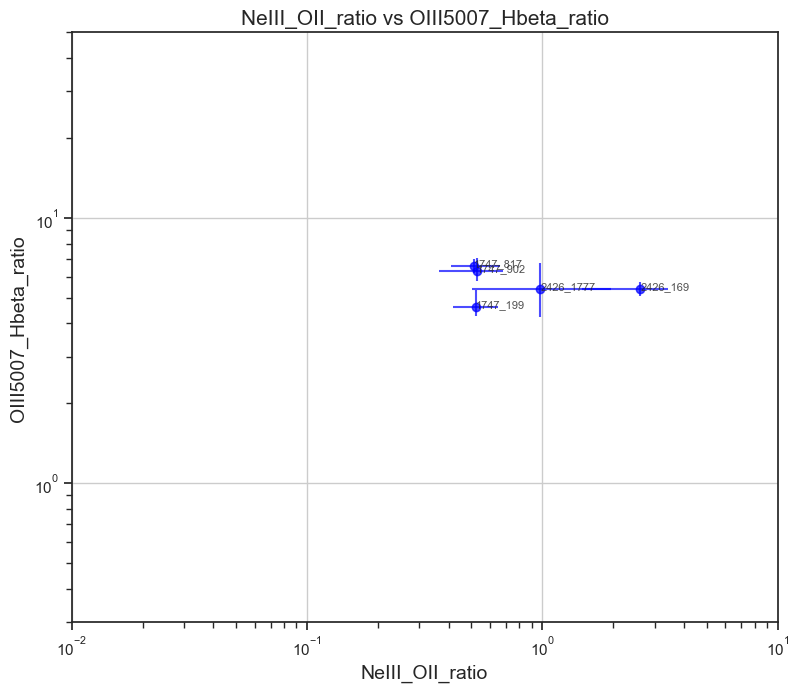

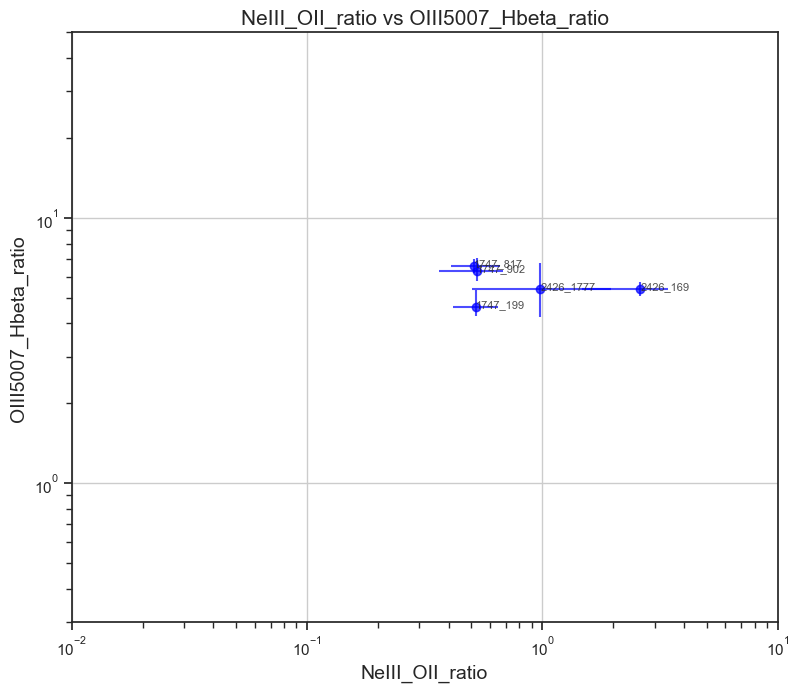

In [97]:
make_bpt(borg_7_full, ratio_x='NeIII_OII_ratio',
    err_x='NeIII_OII_ratio_err',
    ratio_y='OIII5007_Hbeta_ratio',
    err_y='OIII5007_Hbeta_ratio_err')

## Test for the Glass Survey

#### These bins were chosen based on the paper 'GLASS James Webb Space Telescope Early Release Science Program'

Bin 1: 
1.7 < z < 6.5 
Good for lines between O2 and Halpha: 
"Spectral coverage from 1–5 µm will enable the detection of features between [O II] and Hα at 1.7 < z < 6.5"

Bin 2: 
z > 8 
Good for Lymann Alpha studies. 
"At z > 8, NIRSpec will spectrally resolve Lymann alpha..." 

In [ ]:
glass_df = merged_df[merged_df['survey']=='glass']
glass_df = glass_df[(glass_df['z'] > 1.7) & (glass_df['z'] < 6.5)]
glass_df.count()

Galaxy ID                   7
Hdelta_flux                 0
Hdelta_flux_err             0
CIII]_doublet_flux          0
CIII]_doublet_flux_err      0
Hbeta_flux                  0
Hbeta_flux_err              0
[OIII]_5007_flux            0
[OIII]_5007_flux_err        0
OIII]_doublet_flux          0
OIII]_doublet_flux_err      0
[OII]_doublet_flux          0
[OII]_doublet_flux_err      0
Hepsilon_flux               0
Hepsilon_flux_err           0
[OIII]_4959_flux            0
[OIII]_4959_flux_err        0
[NeIII]_flux                0
[NeIII]_flux_err            0
Hgammma_OIII_flux           0
Hgammma_OIII_flux_err       0
CIV_doublet_flux            0
CIV_doublet_flux_err        0
NeIII_OII_ratio             0
NeIII_OII_ratio_err         0
OIII5007_Hbeta_ratio        0
OIII5007_Hbeta_ratio_err    0
Hdelta_Hbeta_ratio          0
Hdelta_Hbeta_ratio_err      0
Hgamma_Hbeta_ratio          0
Hgamma_Hbeta_ratio_err      0
survey                      7
field                       7
prog_id   

In [ ]:
glass_bin_1 = get_df('glass', 100, 1.7, 6.5)
glass_bin_1

Failed on 1324_110000 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1324_150008 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1324_160122 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1324_400009 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1324_50002 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data be

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:87: RuntimeWarning: divide by zero encountered in divide
  g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\fitting.py:1139: RuntimeWarning: invalid value encountered in multiply
  value = np.ravel(weights * (model(*args[2:-1]) - meas))


,Galaxy ID


In [ ]:
filter_galaxy(glass_bin_1, 2)

KeyError: '[NeIII]_flux_SNR'

## Ceers Survey

### Bin 1

 "we found that the evolution of the number density of bright
 (MUV = −20) galaxies was shallowing with increasing redshift at z > 9" 

 " One of the more surprising results to come from the
 CEERS observations is the detection of numerous faint,
 broad-line AGN at z > 5." 


In [ ]:
ceers_df = merged_df[merged_df['survey'] == 'ceers']
ceers_bin_1 = get_df('ceers', 100, 3, 5) 
ceers_bin_1

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: Runti

RMS for 1345_-237 in CIV_window: 0.2398
RMS for 1345_-237 in OII_window: 0.3538
RMS for 1345_-237 in Hb_OIII_window: 0.3569
Final results for 1345_-237: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'NeIII_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1345_-371 in CIV_window: 0.8068
RMS for 1345_-371 in OII_window: 0.1635
RMS for 1345_-371 in Hb_OIII_window: 0.2375
Final results for 1345_-371: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flu

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1345_1019 in CIV_window: 0.47
RMS for 1345_1019 in OII_window: 0.5156
RMS for 1345_1019 in Hb_OIII_window: 0.4711
Final results for 1345_1019: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'NeIII_OII_

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


RMS for 1345_31329 in CIV_window: 0.7583
RMS for 1345_31329 in OII_window: 0.152
RMS for 1345_31329 in Hb_OIII_window: 0.1887
Final results for 1345_31329: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,1345_-237,86.178983,0.756519,"[86.17898343909047, 141.65142494577444]",0.000000,0.000000,"[0.0, 1084.5108869774645]",0.239801,0.356919,148.217820,...,"[0.0, 68.76038987201967]",289.035944,1.858462,"[136.211903218042, 174.83668278336336]",473.216936,2.493308,"[158.00437994642607, 221.5853178081005]",45.462560,0.884556,"[45.462559654283424, 57.329307280184096]"
1,1345_-371,0.000000,0.000000,"[0.0, 1764.4984553767808]",0.000000,0.000000,"[0.0, 1283.0931449599314]",0.806802,0.237523,0.000000,...,"[0.0, 1005.1038067685733]",197.233601,0.478089,"[197.23360063351177, 627.8581423827477]",400.543565,1.124500,"[298.03589768882637, 414.35832541243855]",123.399074,0.474582,"[123.39907424725698, 396.63385576957114]"
2,1345_1019,0.000000,0.000000,"[0.0, 7319.498097261318]",428.011534,0.483088,"[428.0115342050076, 1343.9718714001633]",0.469976,0.471052,705.332785,...,"[279.44087290519997, 783.230720121969]",1682.012143,2.942550,"[586.4367376586513, 556.7974760495003]",4791.738213,7.293484,"[592.2079382281136, 721.7699529944075]",410.951294,0.754030,"[410.95129357939015, 679.0624496078116]"
3,1345_1023,0.000000,0.000000,"[0.0, 80.90848222160116]",141.882792,2.346668,"[82.03440184573253, 38.88837499880876]",0.158429,0.108674,43.276785,...,"[10.920346964946173, 17.286641190074803]",118.456873,4.157931,"[30.091089179319994, 26.887668614189693]",344.921041,10.527586,"[31.51746678128768, 34.00962332242716]",55.260159,1.635873,"[35.02882799427626, 32.53163547707865]"
4,1345_1025,221.121693,1.933641,"[116.24276805216589, 112.46744030695459]",8.277186,0.047601,"[8.27718591531254, 339.49546870149726]",0.359167,0.432571,212.746202,...,"[0.0, 118.49495625946356]",322.869110,3.230408,"[99.17759788202304, 100.71610102982675]",1014.167057,9.681143,"[104.66362688307743, 104.85029206481067]",68.147881,1.080483,"[68.14788131747336, 57.99553909749831]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,1345_829,0.000000,0.000000,"[0.0, 45.17921941970758]",0.000000,0.000000,"[0.0, 69.85195757091577]",0.249662,0.104914,51.532788,...,"[14.520491469679214, 17.121693837411183]",66.106254,4.146794,"[16.507144464245876, 15.375920365574785]",257.104498,16.055692,"[17.5697840333668, 14.456802662580799]",22.979535,1.122186,"[13.299049036335004, 27.65590144524916]"
102,1345_83592,29.883742,0.484867,"[29.883742462589375, 93.38188480950834]",0.000000,0.000000,"[0.0, 10.728617365352575]",0.189360,0.043705,38.811583,...,"[16.670139086778626, 12.704030026964404]",54.836387,7.663856,"[7.12692536762588, 7.1834658034958]",185.933998,12.116619,"[14.127884485411187, 16.562854545148895]",34.130796,1.522413,"[19.646927467362406, 25.190828150158445]"
103,1345_83764,0.000000,0.000000,"[0.0, 49.09050424283282]",36.448658,0.442921,"[36.448658114720175, 128.1343055375571]",0.465019,0.050407,32.814396,...,"[0.0, 0.0]",68.238561,3.286724,"[17.563141789261657, 23.96060985492258]",92.079108,4.116041,"[16.068606432561722, 28.67298278957601]",55.885486,1.363451,"[55.88548628097058, 26.091023974519118]"
104,1345_83772,0.000000,0.000000,"[0.0, 45.72781718180793]",0.000000,0.000000,"[0.0, 34.720591000046646]",0.484035,0.063436,126.499592,...,"[23.55804566469181, 55.62211471042259]",158.000967,4.197089,"[32.54580763293485, 42.744936670773455]",524.353718,12.319150,"[44.961681784476866, 40.166550678038675]",87.565243,1.827636,"[48.13443015906097, 47.68908609358684]"


In [ ]:
filter_galaxy(ceers_bin_1, 2.5)

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
5,1345_1027,22.297854,1.053498,"[22.29785422603958, 20.033207642761443]",52.736606,0.982835,"[52.73660629812049, 54.578659670320334]",0.160205,0.108197,197.993264,...,"[23.247205055589674, 15.245421067280688]",438.043321,31.916267,"[14.31142142548174, 13.13811177365102]",1280.588229,82.208072,"[17.156111808101286, 13.998693360019388]",52.973581,2.701556,"[14.162614706104094, 25.054478163364138]"
8,1345_1065,0.000000,0.000000,"[0.0, 0.0]",39.983991,0.966238,"[39.983991224820386, 42.778251326599204]",0.382632,0.092227,139.712367,...,"[11.54901027364403, 17.05870895292729]",437.015883,17.326347,"[25.761219909206886, 24.68402251168243]",1174.609114,46.794971,"[18.942955927729372, 31.259409389725988]",204.063680,3.932024,"[41.21714689433762, 62.578606066521616]"
12,1345_1143,200.628125,5.179191,"[32.4697035438752, 45.004999025302]",124.666074,1.442285,"[124.66607400994491, 48.20689673380815]",0.142258,0.206375,238.935944,...,"[31.04806608538405, 25.594129035211353]",604.531426,29.335265,"[21.553474249472742, 19.661863547571556]",1926.033645,65.227339,"[34.19470216681111, 24.861321868984533]",192.908050,4.564239,"[45.26743375496284, 39.26277450516466]"
17,1345_1334,0.000000,0.000000,"[0.0, 2.0593744193583254]",0.000000,0.000000,"[0.0, 0.0]",0.312276,0.323786,629.928169,...,"[17.321419796718345, 20.392341812355596]",1064.737994,16.613794,"[68.53992282445961, 59.635256671596835]",3449.714692,68.328118,"[53.83840088252737, 47.136565577207875]",258.039131,14.595112,"[16.756961561508064, 18.602701837811765]"
18,1345_1374,147.477559,1.216140,"[147.47755930963385, 95.05621488483496]",148.690134,1.371901,"[103.44098093138223, 113.32413820699935]",0.414943,0.134435,385.977396,...,"[16.30534145723223, 26.88876971520469]",852.364521,17.944279,"[52.11786869404864, 42.88338810672474]",2100.958646,31.326063,"[60.997398934767034, 73.13746676853634]",327.962597,16.237568,"[18.552887367241908, 21.84264509106174]"
20,1345_1401,525.292502,5.568112,"[114.20982237121245, 74.4690318298334]",89.497954,0.373569,"[89.49795399916411, 389.65353023845296]",0.949750,0.155100,280.213480,...,"[25.037409240297734, 22.81736070261735]",726.586641,18.736477,"[36.37829764750734, 41.18021306643311]",2669.248421,53.490206,"[57.63674874415756, 42.166508627244184]",438.691604,13.962601,"[30.35210668791825, 32.48598490010829]"
23,1345_1518,349.069543,3.604239,"[132.03535000553512, 61.66407509859698]",73.365317,0.518471,"[73.36531665551325, 209.64088934773383]",0.379711,0.114146,362.062850,...,"[9.308324724007463, 22.291449979027092]",753.626083,27.713864,"[19.753402479619467, 34.632812177525125]",2149.383756,88.025392,"[30.85708592534911, 17.978453675926175]",186.852773,9.338290,"[16.126143182633655, 23.89248219763988]"
26,1345_1672,281.588845,1.223211,"[281.588844597866, 178.8202694683872]",0.000000,0.000000,"[0.0, 0.0]",0.917070,0.228049,196.161036,...,"[89.83481687602541, 28.347899299528734]",211.304762,14.033486,"[14.559422131486258, 15.554943671082128]",522.080580,18.298239,"[22.423973668586825, 34.63950384208886]",400.807718,18.234913,"[21.076232450888313, 22.884241596647712]"
27,1345_1677,0.000000,0.000000,"[0.0, 76.45351786990652]",0.000000,0.000000,"[0.0, 0.0]",0.358418,0.079157,106.829879,...,"[36.012188527541895, 13.88415043942824]",206.054873,7.830229,"[16.954633423558818, 35.67597904996299]",671.635563,27.603353,"[24.167900745886527, 24.495430665676395]",143.361353,10.833521,"[12.81317504087474, 13.653077574599735]"
29,1345_1699,274.963193,1.688941,"[270.9573959096461, 54.64695627560627]",118.618588,1.129467,"[71.85171454054142, 138.1917268032634]",0.490941,0.123761,355.00107

In [ ]:
#Might have to modify the Ceers Bins 
ceers_bin_2 = get_df('ceers', 100, 4, 7) 

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: Runti

RMS for 1345_-371 in CIV_window: 0.8068
RMS for 1345_-371 in OII_window: 0.1635
RMS for 1345_-371 in Hb_OIII_window: 0.2375
Final results for 1345_-371: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flu

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


KeyboardInterrupt: 

In [ ]:
# Drop rows with NaNs in any key columns
snr_cols = [col for col in ceers_df.columns if col.endswith('SNR')]
base_cols = ['Galaxy ID', 'NeIII_OII_ratio', 'OIII5007_Hbeta_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio_err']

columns_to_keep = base_cols + snr_cols

# Filter the DataFrame, dropping rows with NaNs in the selected columns
valid_data = ceers_df[columns_to_keep]

valid_data

,Galaxy ID,NeIII_OII_ratio,OIII5007_Hbeta_ratio,NeIII_OII_ratio_err,OIII5007_Hbeta_ratio_err
485,1345_-237,NaN,3.649188,[nan nan],[1.96929404 inf]
486,1345_-371,NaN,NaN,[nan nan],[nan nan]
487,1345_1019,NaN,7.071159,[nan nan],[ 3.78991197 32.86468867]
488,1345_1023,NaN,7.882079,[nan nan],[1.69388223 6.33020823]
489,1345_1025,NaN,4.270118,[nan nan],[1.7269797 5.63070065]
...,...,...,...,...,...
625,1345_829,NaN,5.052759,[nan nan],[1.12325397 1.70463636]
626,1345_83592,0.861385,4.439570,[0.56436223 2.11286151],[1.16676051 2.23557958]
627,1345_83764,NaN,2.948577,[nan nan],[1.21442499 4.78697057]
628,1345_83772,0.739993,4.194059,[0.40050539 1.30014762],[1.04903052 2.30617878]


## Uncover Survey

"In Fig. 6, we show the [O III]+Hβ EW distribution of the full JWST-PRIMAL sample and divided into redshift bins: z = 5.0–6.0, z = 6.0–7.0, z = 7.0–8.0, and z = 8.0–9.5." 

### Bin 1

In [ ]:
uncover_bin_1 = get_df('uncover', 100, 4.5, 5.5)
uncover_bin_1

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_10686 in CIV_window: 0.5146
RMS for 2561_10686 in OII_window: 0.1214
RMS for 2561_10686 in Hb_OIII_window: 0.1221
Final results for 2561_10686: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2561_12881 in CIV_window: 0.5123
RMS for 2561_12881 in OII_window: 0.0655
RMS for 2561_12881 in Hb_OIII_window: 0.0508
Final results for 2561_12881: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2561_14409 in CIV_window: 0.2309
RMS for 2561_14409 in OII_window: 0.04032
RMS for 2561_14409 in Hb_OIII_window: 0.02902
Final results for 2561_14409: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeII

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_10686,0.000000,0.000000,"[0.0, 0.0]",0.000000,0.000000,"[0.0, 107.77248681432022]",0.514606,0.122116,177.542545,...,"[13.853123426202828, 36.3171102858266]",205.881075,19.527914,"[7.984484293925277, 13.101339200345848]",1102.124014,50.367209,"[13.32190566823715, 30.441647713546445]",52.283775,2.375831,"[31.183346301680853, 12.82970059370085]"
1,2561_12881,0.000000,0.000000,"[0.0, 0.0]",0.000000,0.000000,"[0.0, 0.0]",0.512335,0.050804,30.246464,...,"[0.0, 20.372461378297338]",166.823804,1.791504,"[69.10133940066333, 117.1374409061444]",306.468179,4.784210,"[78.35118807365114, 49.765324454619986]",244.083105,2.770275,"[111.19075919022802, 65.02504538506301]"
2,2561_14409,7.973353,0.205402,"[7.9733525062873625, 69.66308753010577]",5.490998,0.118209,"[5.490998109829948, 87.41253542298655]",0.230938,0.029024,19.655100,...,"[8.361075047608576, 17.098442110186603]",-0.000000,0.000000,"[0.0, 0.0]",43.927400,4.284742,"[11.12806846175338, 9.376034825965576]",15.672766,0.926091,"[15.672765748695966, 18.17438486310295]"
3,2561_15719,0.000000,0.000000,"[0.0, 0.0]",0.000000,0.000000,"[0.0, 0.0]",0.475955,0.049305,40.692337,...,"[0.0, 31.297303418265955]",143.342771,2.201161,"[54.84368439050742, 75.39917081768306]",108.656554,3.760774,"[38.3830337205401, 19.401107923819453]",49.500623,2.135668,"[33.80129301372406, 12.554818806817039]"
4,2561_16863,18.442032,0.227463,"[18.4420320064419, 143.71239559140145]",0.000000,0.000000,"[0.0, 0.0]",0.296493,0.290837,329.803501,...,"[13.688575849515132, 12.145859127224952]",903.355712,42.790961,"[18.559940416082895, 23.661860511990085]",2183.504342,98.655879,"[27.174773502414155, 17.09028937076573]",153.834894,13.782797,"[10.169652250744178, 12.153086633545769]"
5,2561_18113,0.000000,0.000000,"[0.0, 0.0]",71.892547,1.159255,"[71.89254666749571, 52.139815496385594]",0.346366,0.036455,9.974925,...,"[59.6412550013803, 72.52546428955705]",11.723076,0.887461,"[11.723076339313021, 14.696279717048064]",72.322336,3.446731,"[18.628230605473924, 23.337523197088785]",5.172807,0.540652,"[5.172806951321451, 13.962640830832179]"
6,2561_18840,0.000000,0.000000,"[0.0, 11.47608709120295]",0.000000,0.000000,"[0.0, 0.0]",0.372260,0.080796,62.983273,...,"[2.1408118237874563, 19.873845680756435]",96.899996,4.201913,"[14.976264015443292, 31.1455859904938]",404.709894,16.313598,"[30.67019552824337, 18.94606873874733]",18.862569,0.651533,"[18.862568535650333, 39.039503599058]"
7,2561_20071,10.038127,0.258133,"[10.03812680575511, 67.73661422971935]",73.575088,1.241573,"[73.57508766363638, 44.94403756848777]",0.276990,0.051230,30.930708,...,"[14.583679002340325, 14.964339894731886]",91.940891,4.375302,"[21.610656940808383, 20.41655982634157]",229.482468,9.901123,"[19.404448691171723, 26.950388341370854]",21.966012,0.992216,"[21.966012295528614, 22.310667105283656]"
8,2561_21527,63.552604,0.827884,"[62.50427404794902, 91.02590961018608]",0.000000,0.000000,"[0.0, 0.0]",0.248145,0.034039,6.161818,...,"[10.05557825184476, 10.099952152569116]",41.065864,2.442756,"[20.44400451516226, 13.178560051906956]",47.534980,4.389706,"[11.114167803534102, 10.543310201128065]",1.382005,0.175050,"[1.38200491868453, 14.407832173654315]"
9,2561_27064,100.670931,1.385252,"[84.52528670082252, 60.82145485388743]",53.222073,0.574656,"[53.222073354047936, 132.00890609897084]",0.632085,0.073707,93.338090,...,"[0.0, 37.04555265335815]",146.395524,2.045860,"[55.994808359696066, 87.11908936947478]",320.492393,7.686905,"[44.25390022058366, 39.132691147236585]",183.191645,5.163489,"[38.884017839893744, 32.0725160487942]"


In [ ]:
uncover_1_filtered = filter_galaxy(uncover_bin_1, 2,['NeIII_OII_ratio','OIII5007_Hbeta_ratio' ])
uncover_1_filtered

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
4,2561_16863,18.442032,0.227463,"[18.4420320064419, 143.71239559140145]",0.000000,0.000000,"[0.0, 0.0]",0.296493,0.290837,329.803501,...,"[13.688575849515132, 12.145859127224952]",903.355712,42.790961,"[18.559940416082895, 23.661860511990085]",2183.504342,98.655879,"[27.174773502414155, 17.09028937076573]",153.834894,13.782797,"[10.169652250744178, 12.153086633545769]"
10,2561_27922,0.000000,0.000000,"[0.0, 260.77483267820287]",367.212768,7.906828,"[57.62669159580338, 35.25828841409117]",0.478252,0.108803,298.812026,...,"[21.350042054664385, 13.246796640604813]",791.688317,18.775521,"[43.28822077221764, 41.043746500798306]",1477.879373,39.226957,"[41.002212730902556, 34.34797968093585]",73.146036,3.624977,"[29.023906237680002, 11.332778853456972]"


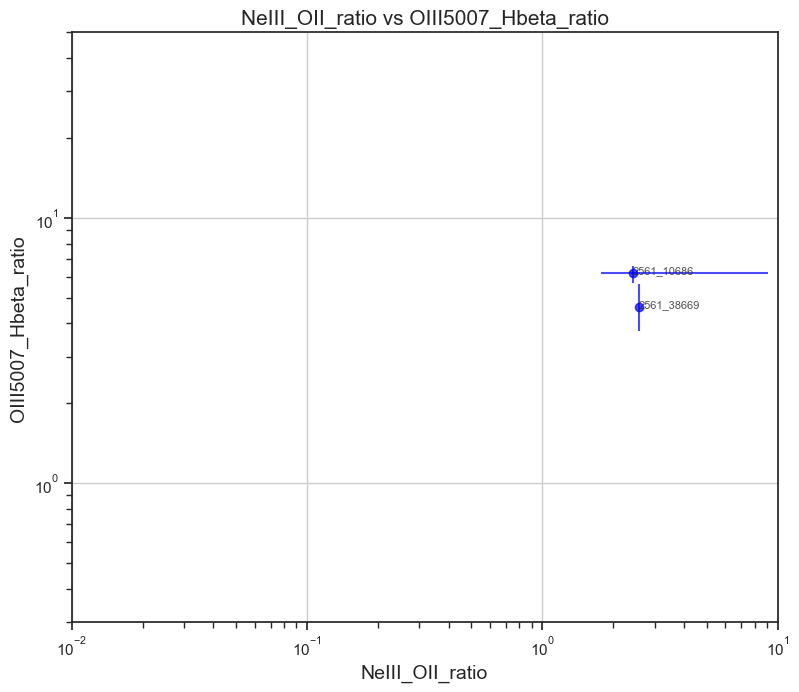

Plotted 2 galaxies


In [ ]:
make_bpt(uncover_1_filtered, ratio_x='NeIII_OII_ratio',
    err_x='NeIII_OII_ratio_err',
    ratio_y='OIII5007_Hbeta_ratio',
    err_y='OIII5007_Hbeta_ratio_err')

### Bin 2

In [ ]:
uncover_bin_2 = get_df('uncover', 100, 5.5, 6.5)
uncover_bin_2

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_10155 in CIV_window: 0.1794
RMS for 2561_10155 in OII_window: 0.03904
RMS for 2561_10155 in Hb_OIII_window: 0.02358
Final results for 2561_10155: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: invalid value encountered in scala

RMS for 2561_10740 in CIV_window: 0.2724
RMS for 2561_10740 in OII_window: 0.06101
RMS for 2561_10740 in Hb_OIII_window: 0.0487
Final results for 2561_10740: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:87: RuntimeWarning: divide by zero encountered in divide
  g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)


RMS for 2561_11045 in CIV_window: 0.2264
RMS for 2561_11045 in OII_window: 0.04894
RMS for 2561_11045 in Hb_OIII_window: 0.06564
Final results for 2561_11045: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeII

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2561_23541 in CIV_window: 0.2248
RMS for 2561_23541 in OII_window: 0.0426
RMS for 2561_23541 in Hb_OIII_window: 0.05064
Final results for 2561_23541: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


RMS for 2561_8613 in CIV_window: 0.2277
RMS for 2561_8613 in OII_window: 0.05948
RMS for 2561_8613 in Hb_OIII_window: 0.03983
Final results for 2561_8613: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_f

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_10155,13.096360,0.385056,"[13.09636031468172, 54.926800524497665]",173.057600,5.160857,"[25.363326776065264, 41.70212844267246]",0.179412,0.023583,48.886271,...,"[17.31085200939722, 21.829038621745454]",59.458707,5.880125,"[9.835839439528336, 10.387782107000803]",192.180758,15.287748,"[12.36376525995783, 12.77803579663373]",0.000000,0.000000,"[0.0, 0.0]"
1,2561_10740,-0.000000,-0.000000,"[50.801709982273515, 0.0]",0.000000,0.000000,"[0.0, 0.0]",0.272391,0.048695,16.603351,...,"[20.637721551422402, 20.36339419930077]",32.794998,2.535537,"[12.030111841498968, 13.83817882040723]",88.349194,4.918197,"[17.501877567800776, 18.425594715108986]",0.000000,0.000000,"[0.0, 18.25566766846111]"
2,2561_11045,4.781964,0.188466,"[4.781964188508596, 45.96419714298962]",0.000000,0.000000,"[0.0, 0.0]",0.226365,0.065636,142.493370,...,"[8.20785244466471, 22.962046538141742]",290.587494,23.050517,"[10.638845314329956, 14.574254297564437]",817.706702,61.427921,"[13.05074742121235, 13.572543352704884]",241.394174,10.168670,"[28.49762917816173, 18.980392586987875]"
3,2561_12065,188.657663,2.337105,"[103.05701381347723, 58.38861176917209]",0.000000,0.000000,"[0.0, 13.110372734657675]",0.358681,0.058789,19.768787,...,"[29.87891168338661, 40.04566703530113]",58.630454,6.639707,"[8.407068075038346, 9.253487003408274]",148.210622,9.601694,"[13.501615609777161, 17.37014808072101]",1.770644,0.046050,"[1.7706444491831723, 75.1296935315365]"
4,2561_13821,0.000000,0.000000,"[0.0, 49.53573376819655]",0.000000,0.000000,"[0.0, 113.31242264470868]",0.180420,0.047589,139.378603,...,"[14.397187317384159, 51.307264375614565]",132.180478,7.766477,"[20.247403676917287, 13.79131794459488]",341.250744,26.405375,"[16.544846349711804, 9.302220129820569]",24.749016,1.806722,"[14.876304677575853, 12.520284090643052]"
5,2561_14354,0.000000,0.000000,"[0.0, 148.83927759962094]",183.789473,1.730484,"[164.92642172778832, 47.487517174874114]",0.476839,0.150284,127.185287,...,"[104.17998874511778, 17.74148479734079]",248.978273,12.678771,"[16.949769200894423, 22.325058778994645]",962.816336,44.713002,"[22.420936235991917, 20.645567804966277]",262.208291,13.390570,"[15.043887021919744, 24.11923771701339]"
6,2561_15227,26.473776,0.510089,"[26.473775840809566, 77.32679940771611]",0.000000,0.000000,"[0.0, 0.0]",0.283279,0.034394,79.296838,...,"[13.691937383871384, 11.579478468855061]",116.708934,6.719426,"[16.856181622403597, 17.881589127388025]",325.587930,14.689553,"[20.49475153459258, 23.83442998036213]",34.226783,2.140131,"[13.049727460308585, 18.9359595715246]"
7,2561_15265,0.000000,0.000000,"[0.0, 38.72236667400938]",32.105746,0.292093,"[32.10574558374593, 187.7265671907403]",0.377706,0.044753,38.874785,...,"[11.63184422496424, 16.551045242001017]",16.986177,0.714221,"[9.969564163992025, 37.59605653205496]",85.833257,4.927548,"[17.149712564519575, 17.688407384377584]",0.000000,0.000000,"[0.0, 17.585390065242947]"
8,2561_16942,136.142231,1.876624,"[97.7208339070327, 47.37185574594264]",20.578552,0.409376,"[20.578552316217948, 79.95751827235007]",0.257923,0.055868,10.670462,...,"[0.05362046189865128, 24.475120314811846]",7.964681,0.725569,"[7.964680530475654, 13.989624350812594]",77.619016,7.739408,"[8.076230204077717, 11.981897900184833]",48.231681,2.363008,"[22.298421309187734, 18.52385160747916]"
9,2561_20972,0.000000,0.000000,"[0.0, 86.2972088486545]",34.524607,0.786043,"[34.524606925386294, 53.31943502587123]",0.212947,0.031838,22.003408,...,"[7.479660386341209, 13.158691119922096]",49.362801,3.302608,"[18.2044221659921, 11.688798963029441]",79.250053,4.657109,"[18.248895483435383, 15.

In [ ]:
uncover_2_filtered = filter_galaxy(uncover_bin_2, 2, ['NeIII_OII_ratio','OIII5007_Hbeta_ratio'])
uncover_2_filtered

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
4,2561_13821,0.000000,0.000000,"[0.0, 0.19537510354107532]",0.048923,0.066849,"[0.048922863050787954, 1.4147653535668734]",0.180420,0.047589,1.444546,...,"[0.1248078138631959, 0.44433448870100023]",1.343608,6.294445,"[0.2840948828634986, 0.14282382865614074]",3.373067,29.534108,"[0.10943500463774258, 0.11898343295703029]",0.246565,2.109816,"[0.09273548333051015, 0.14099591865633784]"
20,2561_27506,0.056919,0.422309,"[0.05691882169975032, 0.2126415667356783]",0.611769,2.494015,"[0.11456403118784214, 0.37602560328590673]",0.068620,0.019080,0.361381,...,"[0.07947031237978694, 0.0961471695779067]",0.665138,11.042149,"[0.06180971394766055, 0.05866278332595609]",1.712630,34.099004,"[0.05616017949312302, 0.044290256832747676]",0.082152,1.320272,"[0.07509770392996032, 0.04934872797534244]"
32,2561_35488,1.860101,1.024811,"[1.860101051378651, 1.7700348194143452]",0.000000,0.000000,"[0.0, 0.0]",0.310273,0.112444,6.499729,...,"[0.2641177655586371, 0.3911080622361607]",12.597960,60.219464,"[0.17560051819796207, 0.2428010959697442]",35.496461,126.571924,"[0.31783920460870974, 0.24305076134134396]",1.488237,15.400605,"[0.08899173508156655, 0.10427818832343827]"
35,2561_36755,0.000000,0.000000,"[0.0, 0.06298567248766791]",1.696171,8.857274,"[0.2747039515778418, 0.10829670813442771]",0.065886,0.017421,0.551442,...,"[0.14323257737398915, 0.06938497533971821]",0.544065,12.545682,"[0.04612255909639612, 0.04061084595416575]",1.749804,44.021616,"[0.03400827110680238, 0.04548921213044688]",0.032568,0.846565,"[0.03256836499541275, 0.04437406460191284]"
47,2561_52621,0.000000,0.000000,"[0.0, 0.5208487765463705]",0.995561,2.551211,"[0.5832920162928348, 0.19716919554126866]",0.205170,0.029338,0.544165,...,"[0.1545550247288648, 0.1468518986730909]",0.958264,12.201206,"[0.09204413227385122, 0.06503277810851227]",3.052783,26.787350,"[0.12502898314598454, 0.1028982419273583]",0.236617,1.545387,"[0.15504711275612906, 0.1511768530963864]"


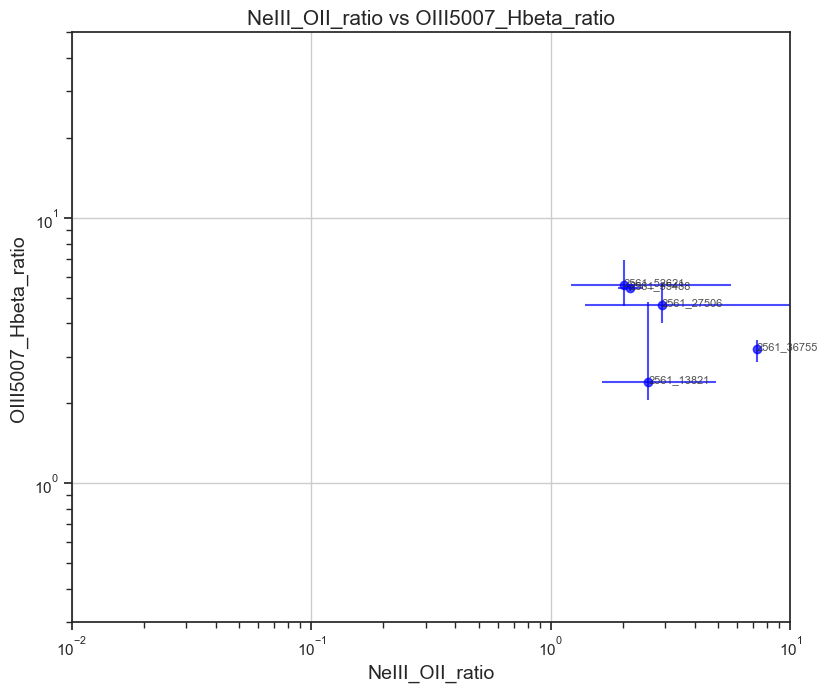

Plotted 5 galaxies


In [ ]:
make_bpt(uncover_2_filtered, ratio_x='NeIII_OII_ratio',
    err_x='NeIII_OII_ratio_err',
    ratio_y='OIII5007_Hbeta_ratio',
    err_y='OIII5007_Hbeta_ratio_err')

In [ ]:
filter_galaxy(uncover_bin_2, 2.5)

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
13,2561_23608,0.000000,0.000000,"[0.0, 331.27626357316103]",261.366564,1.535687,"[261.36656368464855, 79.02392601712279]",0.370771,0.136836,631.773449,...,"[14.99595296343466, 18.080060656018958]",961.316673,39.399469,"[24.729396145358464, 24.069062807554246]",3390.309130,111.791426,"[35.860008214453046, 24.794180402845996]",170.786605,2.618106,"[15.514875105590988, 114.95088219690336]"
21,2561_28110,100.801894,0.794770,"[100.80189445412904, 152.8612892346316]",67.788226,0.734937,"[67.78822564939902, 116.68524518870039]",0.439570,0.119311,244.578253,...,"[15.169381824192186, 11.841562227988106]",718.425304,27.532225,"[30.987141989907627, 21.20081549069755]",1671.718166,59.223700,"[26.030628964165317, 30.423734962062554]",429.826517,22.911122,"[17.1886800182005, 20.332530163210436]"
32,2561_35488,165.275675,0.925877,"[165.27567471466452, 191.73863778377878]",0.000000,0.000000,"[0.0, 0.0]",0.310273,0.112444,649.610204,...,"[18.80987982867981, 34.930512240924145]",1257.089886,67.312160,"[18.102888510039747, 19.248160293059527]",3548.036442,124.864145,"[28.22313229841484, 28.60721622959818]",145.059706,12.190767,"[9.784333644925312, 14.013957402804266]"
52,2561_8943,283.567471,3.911665,"[108.89009388475137, 36.09545218273786]",0.000000,0.000000,"[0.0, 30.423636298308065]",0.539291,0.115594,303.710105,...,"[15.147105360155308, 12.047919321866885]",747.836755,30.784349,"[24.129500319964905, 24.45601735989635]",1960.242557,72.929248,"[27.651559248297872, 26.105818280159156]",123.567053,10.587740,"[9.727106252341528, 13.614428160578129]"


### Bin 3

In [ ]:
uncover_bin_3 = get_df('uncover', 100, 6.5, 7.5)
uncover_bin_3

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_11254 in CIV_window: 0.1027
RMS for 2561_11254 in OII_window: 0.02806
RMS for 2561_11254 in Hb_OIII_window: 0.06059
Final results for 2561_11254: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: divide by zero encountered in scal

RMS for 2561_12899 in CIV_window: 0.07813
RMS for 2561_12899 in OII_window: 0.02693
RMS for 2561_12899 in Hb_OIII_window: 0.02075
Final results for 2561_12899: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeI

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2561_37537 in CIV_window: 0.1136
RMS for 2561_37537 in OII_window: 0.0557
RMS for 2561_37537 in Hb_OIII_window: 0.05339
Final results for 2561_37537: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_11254,0.000000,0.000000,"[0.0, 101.81800360540068]",173.369999,3.340772,"[82.05966194890509, 21.73073219375516]",0.102672,0.060592,151.142925,...,"[3.990921463222591, 4.075535339158115]",163.477211,23.725541,"[7.042264630995447, 6.738429150829063]",425.271692,64.429804,"[6.843668114197442, 6.3574178796963565]",19.533894,1.678249,"[19.533894438389865, 3.7450052815765567]"
1,2561_12899,68.558624,0.351753,"[68.55862380121748, 321.2527919571134]",29.395791,0.967741,"[29.395790897730073, 31.35554736769751]",0.078130,0.020751,20.829666,...,"[5.537143510759845, 0.0]",10.565437,1.655048,"[6.220428641244844, 6.547101711640096]",32.364445,4.286128,"[5.711671303861543, 9.390277565208862]",1.868716,0.365704,"[1.8687158711768368, 8.351122329167163]"
2,2561_13123,17.872916,1.140692,"[17.872915565846384, 13.464041597313916]",5.243255,0.268618,"[5.243254692027984, 33.79547743534434]",0.047752,0.054176,121.725908,...,"[7.609553708182103, 2.617825307503871]",11.567834,0.915899,"[11.567833724403041, 13.69223461196595]",20.581259,1.730222,"[17.88213002490594, 5.908183908286059]",0.000000,0.000000,"[0.0, 0.0]"
3,2561_15383,29.781695,1.325569,"[20.905927712956128, 24.028270781918224]",69.068052,2.663470,"[40.71623798039035, 11.146972518394563]",0.087394,0.078397,161.493418,...,"[20.150243743304088, 3.577243175132331]",0.000000,0.000000,"[0.0, 7.496562742659356]",33.035881,3.571807,"[14.754392683888248, 3.7437408397563274]",0.000000,0.000000,"[0.0, 1.8547830627214659]"
4,2561_16155,23.537126,0.551320,"[23.53712600837907, 61.8474853112805]",68.238280,1.646924,"[64.6875498963265, 18.179980835371182]",0.089690,0.031117,68.998764,...,"[15.885089907090938, 14.18994592544793]",76.711981,11.672929,"[6.6587277141927075, 6.4848420881510975]",259.205016,39.705551,"[6.857971226749896, 6.1983903076340425]",7.871759,0.956691,"[7.871758730680401, 8.584466053628617]"
5,2561_16594,5.132384,0.341653,"[5.132383581305245, 24.912072945205264]",0.000000,0.000000,"[0.0, 0.0]",0.051155,0.033930,75.612302,...,"[0.0, 3.376396440190441]",11.885893,2.585147,"[7.178351210232538, 2.01717525574076]",12.088585,3.610128,"[4.031735418090237, 2.6653036318054095]",4.874250,1.090152,"[4.874249846151476, 4.068082031557828]"
6,2561_2008,0.000000,0.000000,"[0.0, 32.510349252458454]",34.189084,0.684930,"[34.18908354747161, 65.64321708172072]",0.102813,0.035714,40.708890,...,"[25.722027249851102, 15.44305861167566]",6.062025,0.646096,"[6.0620254307971635, 12.703063559373849]",55.412433,6.532357,"[9.520811838231197, 7.444713378816907]",2.689166,0.228657,"[2.689165645544911, 20.832261510053698]"
7,2561_23619,-5.024948,-0.601083,"[11.694690181183457, 5.024947893825934]",-10.864391,-0.639341,"[23.12183928213249, 10.864390602559858]",0.062903,0.027749,15.783011,...,"[4.007739834885857, 4.770671771985114]",17.602110,5.872091,"[2.552441523971753, 3.4427343209812804]",58.416649,14.456898,"[3.724263222256809, 4.357227976665044]",0.000000,0.000000,"[0.0, 5.000160494923394]"
8,2561_27335,0.000000,0.000000,"[0.0, 11.094697672599466]",0.000000,0.000000,"[0.0, 8.04634487856106]",0.081510,0.021229,17.188603,...,"[1.9548336156495978, 8.927704429405155]",9.745182,1.155457,"[9.383314460115296, 7.484792051420186]",37.772228,6.611021,"[5.664837591859353, 5.7622106823480905]",2.303916,0.547767,"[2.3039156969091277, 6.108109936614547]"
9,2561_28876,41.341206,1.059869,"[29.166913593257853, 48.84499915423048]",6.616751,0.283693,"[6.616751100209525, 40.03046759938333]",0.075487,0.025245,81.697584,...,"[0.0, 5.782698912269273]",15.421198,4.079577,"[4.339952811335474, 3.2202415481314883]",27.220245,2.849773,"[6.0846814535218

In [ ]:
uncover_3_filtered = filter_galaxy(uncover_bin_3, 2, ['NeIII_OII_ratio','OIII5007_Hbeta_ratio'] )
uncover_3_filtered

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_11254,0.000000,0.000000,"[0.0, 0.7397756156416141]",1.773314,2.910814,"[1.0118209104544227, 0.2066111264694961]",0.102672,0.060592,1.511809,...,"[0.039261486930849576, 0.038320697524143243]",1.639969,22.055777,"[0.0647075813757727, 0.08400347875697567]",4.241752,72.234019,"[0.05358672057035285, 0.06385799761747002]",0.190723,1.632210,"[0.19072297486641998, 0.04297609792235921]"
15,2561_41225,0.552674,1.106384,"[0.5526738278162284, 0.44638948583901394]",0.000000,0.000000,"[0.0, 0.5463615854957891]",0.105424,0.050584,1.153581,...,"[0.07984248465147781, 0.07998114483698138]",1.355904,8.919295,"[0.16362286634921985, 0.14041562230594273]",3.982945,42.625513,"[0.09441864464243066, 0.09246216147688546]",0.211101,1.721443,"[0.1693980819513189, 0.07586207758710717]"


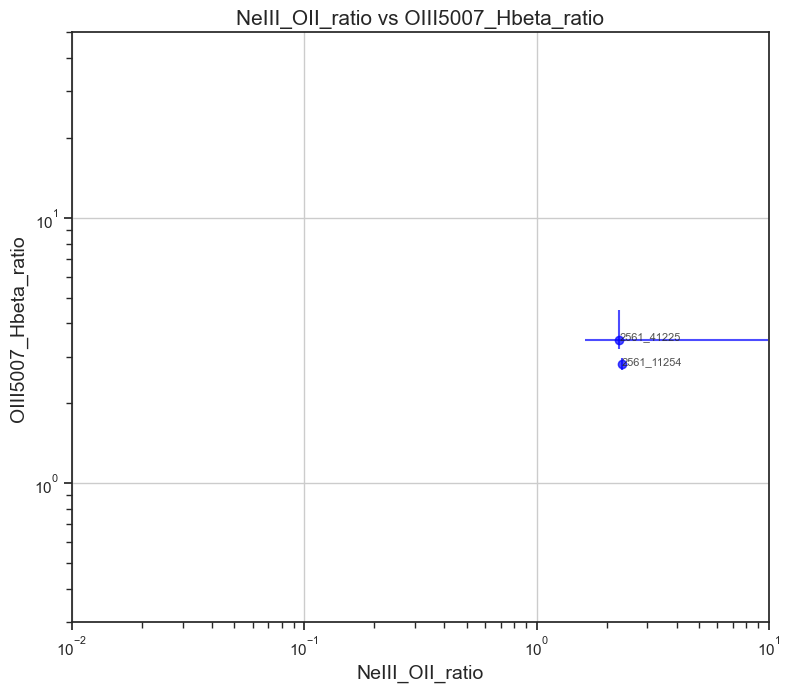

Plotted 2 galaxies


In [ ]:
make_bpt(uncover_3_filtered, ratio_x='NeIII_OII_ratio',
    err_x='NeIII_OII_ratio_err',
    ratio_y='OIII5007_Hbeta_ratio',
    err_y='OIII5007_Hbeta_ratio_err')

### Bin 4

In [ ]:
uncover_bin_4 = get_df('uncover', 100, 7.5, 8.5)
uncover_bin_4

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_18924 in CIV_window: 0.0464
RMS for 2561_18924 in OII_window: 0.01734
RMS for 2561_18924 in Hb_OIII_window: 0.02536
Final results for 2561_18924: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_23604 in CIV_window: 0.05362
RMS for 2561_23604 in OII_window: 0.02614
RMS for 2561_23604 in Hb_OIII_window: 0.03292
Final results for 2561_23604: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeI

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2561_38059 in CIV_window: 0.07954
RMS for 2561_38059 in OII_window: 0.09113
RMS for 2561_38059 in Hb_OIII_window: 0.05963
Final results for 2561_38059: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'N

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_18924,0.0,0.0,"[0.0, 0.0]",5.061615,0.446370,"[5.061615226438281, 17.617413465621578]",0.046399,0.025358,28.209260,...,"[11.159357336016434, 7.035402616808572]",62.860854,9.197548,"[6.189867348523428, 7.479178716999925]",137.858316,27.167261,"[5.031382090499477, 5.1174741959080166]",6.253914,0.841931,"[6.253913622183926, 8.602206370754448]"
1,2561_23604,0.0,0.0,"[0.0, 31.844745918024728]",98.538117,4.242858,"[20.69110114307783, 25.757837625530712]",0.053618,0.032921,53.746248,...,"[8.23358984087024, 9.252220255390776]",23.991986,2.528248,"[6.74390373297603, 12.23523373975986]",110.778176,12.432664,"[9.020367935178825, 8.800137151058706]",0.000000,0.000000,"[0.0, 8.448656450999664]"
2,2561_24531,0.0,0.0,"[0.0, 23.531567957654904]",0.000000,0.000000,"[0.0, 22.265467679646083]",0.160128,0.093453,209.174308,...,"[47.3774844484081, 17.94479798721673]",440.559896,36.439040,"[11.208057374737962, 12.97259601311356]",1207.645594,68.961283,"[13.80424828736659, 21.21962426207392]",112.794698,4.307950,"[19.711757596524663, 32.65407962434732]"
3,2561_38059,0.0,0.0,"[0.0, 0.0]",0.000000,0.000000,"[0.0, 0.0]",0.079543,0.059633,33.942025,...,"[0.0, 10.279558165579926]",23.520307,1.623904,"[10.827545430713299, 18.14005705469747]",128.344171,10.174523,"[15.059103656846446, 10.169434994859643]",51.892740,3.552471,"[15.394146166298725, 13.820867449148146]"
4,2561_60157,0.0,0.0,"[0.0, 0.8967057073290069]",0.000000,0.000000,"[0.0, 0.0]",0.095318,0.049976,43.570420,...,"[3.0469794488852884, 22.972286002551314]",138.867916,7.065826,"[17.870035382299747, 21.436879664629004]",332.571999,29.760447,"[12.94327794262449, 9.406655323801772]",157.554539,12.477213,"[12.635353367427768, 12.61941146359922]"


In [ ]:
filter_galaxy(uncover_bin_4, 2.5)

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
2,2561_24531,0.0,0.0,"[0.0, 23.531567957654904]",0.0,0.0,"[0.0, 22.265467679646083]",0.160128,0.093453,209.174308,...,"[47.3774844484081, 17.94479798721673]",440.559896,36.439040,"[11.208057374737962, 12.97259601311356]",1207.645594,68.961283,"[13.80424828736659, 21.21962426207392]",112.794698,4.307950,"[19.711757596524663, 32.65407962434732]"
4,2561_60157,0.0,0.0,"[0.0, 0.8967057073290069]",0.0,0.0,"[0.0, 0.0]",0.095318,0.049976,43.570420,...,"[3.0469794488852884, 22.972286002551314]",138.867916,7.065826,"[17.870035382299747, 21.436879664629004]",332.571999,29.760447,"[12.94327794262449, 9.406655323801772]",157.554539,12.477213,"[12.635353367427768, 12.61941146359922]"


In [ ]:
filter_galaxy(uncover_bin_4, 2.5, ['NeIII_OII_ratio','OIII5007_Hbeta_ratio'])

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
2,2561_24531,0.0,0.0,"[0.0, 23.531567957654904]",0.0,0.0,"[0.0, 22.265467679646083]",0.160128,0.093453,209.174308,...,"[47.3774844484081, 17.94479798721673]",440.559896,36.439040,"[11.208057374737962, 12.97259601311356]",1207.645594,68.961283,"[13.80424828736659, 21.21962426207392]",112.794698,4.307950,"[19.711757596524663, 32.65407962434732]"
4,2561_60157,0.0,0.0,"[0.0, 0.8967057073290069]",0.0,0.0,"[0.0, 0.0]",0.095318,0.049976,43.570420,...,"[3.0469794488852884, 22.972286002551314]",138.867916,7.065826,"[17.870035382299747, 21.436879664629004]",332.571999,29.760447,"[12.94327794262449, 9.406655323801772]",157.554539,12.477213,"[12.635353367427768, 12.61941146359922]"


In [ ]:
uncover_bin_5 = get_df('uncover', 100, 8.5, 9.5)
uncover_bin_5

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 2561_10646 in CIV_window: 0.2681
RMS for 2561_10646 in OII_window: 0.1818
RMS for 2561_10646 in Hb_OIII_window: 1.123
Final results for 2561_10646: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'NeIII

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_20466 in CIV_window: 0.1021
RMS for 2561_20466 in OII_window: 0.05736
RMS for 2561_20466 in Hb_OIII_window: 0.1057
Final results for 2561_20466: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'NeI

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_10646,600.660780,23.702525,"[22.15237072867592, 28.530903921101867]",613.266966,26.935426,"[24.34889093422646, 21.18719694699996]",0.268092,1.123404,994.239925,...,"[46.587787214102775, 31.05272155525131]",2917.07340,121.174118,"[25.118980150281914, 23.02782627661736]",7258.266306,256.551517,"[25.2368099761934, 31.34649465209077]",243.923012,20.510499,"[7.2271293932167, 16.5580564267608]"
1,2561_20466,32.506925,0.773488,"[32.50692481278767, 51.54592209412439]",25.351487,0.777890,"[25.351487240654045, 39.82862948317685]",0.102093,0.105672,237.420562,...,"[17.562263725496074, 16.185623758836925]",178.89727,9.153598,"[20.53414625281718, 18.553713408512124]",457.014140,28.432121,"[14.91508781010998, 17.232647256600842]",24.705201,1.767460,"[12.354284148903194, 15.601310210206897]"


In [ ]:
filter_galaxy(uncover_bin_5, 2.5, ['NeIII_OII_ratio','OIII5007_Hbeta_ratio'])

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_10646,600.66078,23.702525,"[22.15237072867592, 28.530903921101867]",613.266966,26.935426,"[24.34889093422646, 21.18719694699996]",0.268092,1.123404,994.239925,...,"[46.587787214102775, 31.05272155525131]",2917.0734,121.174118,"[25.118980150281914, 23.02782627661736]",7258.266306,256.551517,"[25.2368099761934, 31.34649465209077]",243.923012,20.510499,"[7.2271293932167, 16.5580564267608]"


In [ ]:
uncover_bin_6 = get_df('uncover', 100, 9.5, 10)
uncover_bin_6

Failed on 2561_13151 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 2561_22223 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Processed 0 galaxies


c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


,Galaxy ID


# Automated Process for all Galaxies 

In [77]:
raw_df['survey'].value_counts()

survey
rubies        394
jades         323
canucs        150
ceers         145
uncover       108
castellano     87
eisenstein     40
arrabal        25
coe            21
borg           14
chen           13
glass          12
stark           8
borg_fs         7
kelly           6
glazebrook      6
smacs           5
Name: count, dtype: int64

In [86]:
rubies_df = raw_df[raw_df['survey'] == 'rubies']
rubies_df[(rubies_df['z'] > 6) & (rubies_df['z'] < 7)]

,survey,field,prog_id,id,Galaxy ID,ra,dec,z,flag_lya,flag_agn,flag_z
1007,rubies,egs,4233,975193,4233_975193,214.967248,52.963630,6.991,-99,-99,-99
1008,rubies,egs,4233,966103,4233_966103,214.985495,52.958748,6.986,-99,-99,-99
1009,rubies,egs,4233,55604,4233_55604,214.983026,52.956001,6.976,-99,1,-99
1010,rubies,egs,4233,922409,4233_922409,214.850856,52.776674,6.961,-99,-99,-99
1011,rubies,egs,4233,945424,4233_945424,214.878422,52.838464,6.960,-99,-99,-99
...,...,...,...,...,...,...,...,...,...,...,...
1273,rubies,uds,4233,14947,4233_14947,34.348917,-5.295289,6.068,-99,-99,-99
1274,rubies,uds,4233,18611,4233_18611,34.461166,-5.289354,6.044,-99,-99,-99
1275,rubies,uds,4233,12073,4233_12073,34.473619,-5.300146,6.043,-99,-99,-99
1276,rubies,uds,4233,125917,4233_125917,34.478046,-5.168718,6.037,-99,-99,-99


In [92]:
for survey in set(raw_df.survey): 
    print(f"max z for {survey}: {max(raw_df[raw_df['survey'] == survey]['z'])}")
    print(f"min z for {survey}: {min(raw_df[raw_df['survey'] == survey]['z'])}")
    print(f"avg z for {survey}: {np.mean(raw_df[raw_df['survey'] == survey]['z'])}")

max z for chen: 9.798
min z for chen: 5.02
avg z for chen: 6.621846153846153
max z for ceers: 10.81
min z for ceers: 4.996
avg z for ceers: 6.344220689655173
max z for arrabal: 11.4
min z for arrabal: 5.095
avg z for arrabal: 7.26156
max z for coe: 10.182
min z for coe: 5.238
avg z for coe: 6.592952380952381
max z for glass: 9.313
min z for glass: 5.135
avg z for glass: 6.679250000000001
max z for borg_fs: 8.49
min z for borg_fs: 7.337
avg z for borg_fs: 8.079142857142857
max z for smacs: 8.498
min z for smacs: 5.275
avg z for smacs: 7.0968
max z for uncover: 12.908
min z for uncover: 5.016
avg z for uncover: 6.39337962962963
max z for eisenstein: 12.926
min z for eisenstein: 5.032
avg z for eisenstein: 6.828299999999999
max z for rubies: 9.309
min z for rubies: 5.005
avg z for rubies: 6.322822335025381
max z for kelly: 9.51
min z for kelly: 5.294
avg z for kelly: 7.2076666666666656
max z for canucs: 9.866
min z for canucs: 5.005
avg z for canucs: 6.437593333333333
max z for stark: 7.8

In [98]:
# Optimized redshift bins for each survey (edit as needed for your science goals)
bpt_base_path = "bpt_plots"
os.makedirs(bpt_base_path, exist_ok=True)

survey_bins = {
    'rubies':      [(5, 5.5), (5.5, 6), (6.5, 7.5), (7.5, 9.4)],
    'jades':       [(5.0, 5.8), (5.8, 6.7), (6.7, 7.7), (7.7, 9.0), (9.0, 11.6)],
    'canucs':      [(5.0, 5.8), (5.8, 6.5), (6.5, 7.5), (7.5, 9.0)],
    'castellano':  [(5.0, 5.8), (5.8, 6.5), (6.5, 7.5), (7.5, 9.5), (9.5, 12.4)],
    'eisenstein':  [(5.0, 6.0), (6.0, 7.0), (7.0, 8.5), (8.5, 10.5), (10.5, 13.0)],
    'arrabal':     [(5.0, 6.0), (6.0, 7.2), (7.2, 8.5), (8.5, 11.5)],
    'coe':         [(5.2, 6.2), (6.2, 7.2), (7.2, 8.5), (8.5, 10.2)],
    'chen':        [(5.0, 6.0), (6.0, 7.0), (7.0, 8.5), (8.5, 9.8)],
    'stark':       [(5.3, 6.2), (6.2, 7.0), (7.0, 7.9)],
    'kelly':       [(5.3, 6.5), (6.5, 7.5), (7.5, 9.5)],
    'glazebrook':  [(5.3, 6.0), (6.0, 6.7), (6.7, 7.2)],
    'smacs':       [(5.3, 6.5), (6.5, 7.5), (7.5, 8.5)],
    # If you want to process borg/borg_fs, add bins here
    # 'borg':      [(7.5, 8.5)],
    # 'borg_fs':   [(7.5, 8.5)],
}

# Surveys already processed or handled separately
excluded_surveys = ['glass', 'uncover', 'ceers', 'borg', 'borg_fs']

# Line ratios for filtering and plotting
line_ratios_for_filter = ['NeIII_OII_SNR', 'OIII5007_Hbeta_SNR']
ratio_x = 'NeIII_OII_ratio'
err_x = 'NeIII_OII_ratio_err'
ratio_y = 'OIII5007_Hbeta_ratio'
err_y = 'OIII5007_Hbeta_ratio_err'

# Get unique surveys from your dataset
all_surveys = proc_df['survey'].unique()

for survey in all_surveys:
    survey_lower = survey.lower()
    if survey_lower in excluded_surveys:
        continue  # Skip excluded surveys

    bins = survey_bins.get(survey_lower)
    if bins is not None:
        for zmin, zmax in bins:
            # 1️⃣ Extract dataframe for this survey and redshift bin
            df_subset = get_df(survey, 100, zmin, zmax)

            # 2️⃣ Filter for SNR > 2 for both ratios
            df_snr = filter_galaxy(df_subset, SNR_filter=2, line_ratios=line_ratios_for_filter)

            # 3️⃣ Generate BPT diagram if df_snr is not empty
            if not df_snr.empty:
                fig = make_bpt(
                    df_snr,
                    ratio_x=ratio_x,
                    err_x=err_x,
                    ratio_y=ratio_y,
                    err_y=err_y,
                    title=f"{survey} z={zmin}-{zmax}",
                    x_label=r"[NeIII]/[OII]",
                    y_label=r"[OIII]/Hβ",
                    xscale='log',
                    yscale='log',
                    xlim=(0.01, 10),
                    ylim=(0.3, 50)
                )

                # Save the plot
                if fig:
                    survey_plot_dir = os.path.join(bpt_base_path, survey)
                    os.makedirs(survey_plot_dir, exist_ok=True)
                    plot_filename = f"{survey}_z_{zmin}_to_{zmax}.png"
                    plot_path = os.path.join(survey_plot_dir, plot_filename)
                    fig.savefig(plot_path)
                    plt.close(fig)
                    print(f"Saved BPT plot to: {plot_path}")
            else:
                print(f"No galaxies passed SNR filter in {survey} z={zmin}-{zmax}.")
    else:
        print(f"⚠️ No redshift bins defined for survey '{survey}' — skipping.")


RMS for 1180_10013169 in CIV_window: 0.3674
RMS for 1180_10013169 in OII_window: 0.1209
RMS for 1180_10013169 in Hb_OIII_window: 0.2481
Final results for 1180_10013169: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', '

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1180_10013534 in CIV_window: 0.2684
RMS for 1180_10013534 in OII_window: 0.05275
RMS for 1180_10013534 in Hb_OIII_window: 0.03612
Final results for 1180_10013534: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err',

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1180_103483 in CIV_window: 0.5408
RMS for 1180_103483 in OII_window: 0.08181
RMS for 1180_103483 in Hb_OIII_window: 0.05401
Final results for 1180_103483: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammm

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykern

RMS for 1180_13169 in CIV_window: 2.638
RMS for 1180_13169 in OII_window: 0.608
RMS for 1180_13169 in Hb_OIII_window: 0.477
Final results for 1180_13169: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_fl

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


RMS for 1180_13885 in CIV_window: 0.103
RMS for 1180_13885 in OII_window: 0.02748
RMS for 1180_13885 in Hb_OIII_window: 0.0423
Final results for 1180_13885: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: Runti

RMS for 1180_12336 in CIV_window: 0.4458
RMS for 1180_12336 in OII_window: 0.08504
RMS for 1180_12336 in Hb_OIII_window: 0.05631
Final results for 1180_12336: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1180_131737 in CIV_window: 0.1307
RMS for 1180_131737 in OII_window: 0.03657
RMS for 1180_131737 in Hb_OIII_window: 0.07776
Final results for 1180_131737: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammm

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1180_13556 in CIV_window: 0.2362
RMS for 1180_13556 in OII_window: 0.06621
RMS for 1180_13556 in Hb_OIII_window: 0.07721
Final results for 1180_13556: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1180_13607 in CIV_window: 0.2047
RMS for 1180_13607 in OII_window: 0.08371
RMS for 1180_13607 in Hb_OIII_window: 0.05252
Final results for 1180_13607: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1180_8624 in CIV_window: 0.2125
RMS for 1180_8624 in OII_window: 0.06238
RMS for 1180_8624 in Hb_OIII_window: 0.05737
Final results for 1180_8624: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_f

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 1180_11547 in CIV_window: 0.2107
RMS for 1180_11547 in OII_window: 0.07699
RMS for 1180_11547 in Hb_OIII_window: 0.06478
Final results for 1180_11547: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\

RMS for 1180_13173 in CIV_window: 0.1429
RMS for 1180_13173 in OII_window: 0.05126
RMS for 1180_13173 in Hb_OIII_window: 0.07047
Final results for 1180_13173: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1180_13552 in CIV_window: 0.09018
RMS for 1180_13552 in OII_window: 0.03876
RMS for 1180_13552 in Hb_OIII_window: 0.04615
Final results for 1180_13552: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_O

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1180_13908 in CIV_window: 0.1164
RMS for 1180_13908 in OII_window: 0.04565
RMS for 1180_13908 in Hb_OIII_window: 0.05981
Final results for 1180_13908: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 1180_134422 in CIV_window: 0.1484
RMS for 1180_134422 in OII_window: 0.04423
RMS for 1180_134422 in Hb_OIII_window: 0.09392
Final results for 1180_134422: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err',

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1180_5173 in CIV_window: 0.1178
RMS for 1180_5173 in OII_window: 0.04846
RMS for 1180_5173 in Hb_OIII_window: 0.07011
Final results for 1180_5173: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII50

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1181_1899 in CIV_window: 0.06805
RMS for 1181_1899 in OII_window: 0.03189
RMS for 1181_1899 in Hb_OIII_window: 0.08125
Final results for 1181_1899: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipyker

RMS for 1181_54165 in CIV_window: 0.1862
RMS for 1181_54165 in OII_window: 0.08231
RMS for 1181_54165 in Hb_OIII_window: 0.1372
Final results for 1181_54165: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OII

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


Failed on 1181_3990 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1181_3991 due to: zero-size array to reduction operation fmin which has no identity
Failed on 1181_55757 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1210_14177 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1210_14220 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1210_58975 due to: Objective function has encountered a non-finite value,

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1208_15784 in CIV_window: 0.9214
RMS for 1208_15784 in OII_window: 0.1808
RMS for 1208_15784 in Hb_OIII_window: 0.1391
Final results for 1208_15784: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1208_16952 in CIV_window: 0.5646
RMS for 1208_16952 in OII_window: 0.1159
RMS for 1208_16952 in Hb_OIII_window: 0.06657
Final results for 1208_16952: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Final results for 1208_204208: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio'

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1208_204889 in CIV_window: 0.5085
RMS for 1208_204889 in OII_window: 0.07021
RMS for 1208_204889 in Hb_OIII_window: 0.07309
Final results for 1208_204889: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammm

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1208_2110397 in CIV_window: 0.395
RMS for 1208_2110397 in OII_window: 0.1036
RMS for 1208_2110397 in Hb_OIII_window: 0.06232
Final results for 1208_2110397: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgam

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


RMS for 1208_3104035 in CIV_window: 0.3203
RMS for 1208_3104035 in OII_window: 0.06148
RMS for 1208_3104035 in Hb_OIII_window: 0.06011
Final results for 1208_3104035: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hg

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127:

RMS for 1208_11756 in CIV_window: 0.4278
RMS for 1208_11756 in OII_window: 0.1311
RMS for 1208_11756 in Hb_OIII_window: 0.1394
Final results for 1208_11756: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1208_202967 in CIV_window: 0.3074
RMS for 1208_202967 in OII_window: 0.08731
RMS for 1208_202967 in Hb_OIII_window: 0.09598
Final results for 1208_202967: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammm

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1208_3112614 in CIV_window: 0.4555
RMS for 1208_3112614 in OII_window: 0.08953
RMS for 1208_3112614 in Hb_OIII_window: 0.1002
Final results for 1208_3112614: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hga

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: Runt

RMS for 1208_-4 in CIV_window: 0.2728
RMS for 1208_-4 in OII_window: 0.08022
RMS for 1208_-4 in Hb_OIII_window: 0.1032
Final results for 1208_-4: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR',

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1208_15496 in CIV_window: 0.3955
RMS for 1208_15496 in OII_window: 0.102
RMS for 1208_15496 in Hb_OIII_window: 0.1044
Final results for 1208_15496: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1208_8489 in CIV_window: 0.2361
RMS for 1208_8489 in OII_window: 0.113
RMS for 1208_8489 in Hb_OIII_window: 0.1088
Final results for 1208_8489: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: Runt

RMS for 1208_202264 in CIV_window: 0.2003
RMS for 1208_202264 in OII_window: 0.1072
RMS for 1208_202264 in Hb_OIII_window: 0.1196
Final results for 1208_202264: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', '

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1208_2101179 in CIV_window: 0.5671
RMS for 1208_2101179 in OII_window: 0.1682
RMS for 1208_2101179 in Hb_OIII_window: 0.1723
Final results for 1208_2101179: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgam

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1208_2112699 in CIV_window: 0.2592
RMS for 1208_2112699 in OII_window: 0.08287
RMS for 1208_2112699 in Hb_OIII_window: 0.1122
Final results for 1208_2112699: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hga

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 1433_1120 in CIV_window: 1.228
RMS for 1433_1120 in OII_window: 0.2063
RMS for 1433_1120 in Hb_OIII_window: 0.2494
Final results for 1433_1120: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\i

RMS for 1433_1686 in CIV_window: 0.2067
RMS for 1433_1686 in OII_window: 0.0776
RMS for 1433_1686 in Hb_OIII_window: 0.05312
Final results for 1433_1686: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_fl

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:87: RuntimeWarning: divide by zero encountered in divide
  g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\fitting.py:1139: RuntimeWarning: invalid value encountered in multiply
  value = np.ravel(weights * (model(*args[2:-1]) - meas))


RMS for 1433_3208 in CIV_window: 0.2995
RMS for 1433_3208 in OII_window: 0.09179
RMS for 1433_3208 in Hb_OIII_window: 0.08152
Final results for 1433_3208: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_f

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1433_3887 in CIV_window: 0.1711
RMS for 1433_3887 in OII_window: 0.04797
RMS for 1433_3887 in Hb_OIII_window: 0.04678
Final results for 1433_3887: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_f

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1433_4188 in CIV_window: 0.2854
RMS for 1433_4188 in OII_window: 0.06928
RMS for 1433_4188 in Hb_OIII_window: 0.05587
Final results for 1433_4188: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_f

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1433_3754 in CIV_window: 0.1508
RMS for 1433_3754 in OII_window: 0.05057
RMS for 1433_3754 in Hb_OIII_window: 0.06063
Final results for 1433_3754: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_f

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


Failed on 1433_3568 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1433_3593 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Processed 0 galaxies
Saved DataFrame to: Users/isaia/OneDrive/Documents/UCLA/UCLA REU 2025/Data/Test Data Bins/coe\coe_z_8.5_to_10.2.pkl
No galaxies passed SNR filter in coe z=8.5-10.2.
Failed on 2478_11174_0151 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 2478_1_0151 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoi

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:87: RuntimeWarning: divide by zero encountered in divide
  g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\fitting.py:1139: RuntimeWarning: invalid value encountered in multiply
  value = np.ravel(weights * (model(*args[2:-1]) - meas))
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII

RMS for 2565_15294 in CIV_window: 0.5155
RMS for 2565_15294 in OII_window: 0.07458
RMS for 2565_15294 in Hb_OIII_window: 0.05243
Final results for 2565_15294: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2565_8032 in CIV_window: 0.575
RMS for 2565_8032 in OII_window: 0.09352
RMS for 2565_8032 in Hb_OIII_window: 0.0592
Final results for 2565_8032: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flu

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Saved BPT plot to: bpt_plots\glazebrook\glazebrook_z_5.3_to_6.0.png


c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 2565_19780 in CIV_window: 0.3286
RMS for 2565_19780 in OII_window: 0.06923
RMS for 2565_19780 in Hb_OIII_window: 0.1128
Final results for 2565_19780: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OII

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2565_15420 in CIV_window: 0.8016
RMS for 2565_15420 in OII_window: 0.2634
RMS for 2565_15420 in Hb_OIII_window: 0.2963
Final results for 2565_15420: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2750_1768 in CIV_window: 0.102
RMS for 2750_1768 in OII_window: 0.0273
RMS for 2750_1768 in Hb_OIII_window: 0.03633
Final results for 2750_1768: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flu

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 2750_2315 in CIV_window: 0.2363
RMS for 2750_2315 in OII_window: 0.05149
RMS for 2750_2315 in Hb_OIII_window: 0.05387
Final results for 2750_2315: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_f

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykern

RMS for 2750_7467 in CIV_window: 0.2007
RMS for 2750_7467 in OII_window: 0.0662
RMS for 2750_7467 in Hb_OIII_window: 0.03943
Final results for 2750_7467: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_fl

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 2750_445 in CIV_window: 0.06568
RMS for 2750_445 in OII_window: 0.0258
RMS for 2750_445 in Hb_OIII_window: 0.02125
Final results for 2750_445: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2750_617 in CIV_window: 0.1478
RMS for 2750_617 in OII_window: 0.04493
RMS for 2750_617 in Hb_OIII_window: 0.05568
Final results for 2750_617: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: Runtim

RMS for 2750_1312 in CIV_window: 0.1451
RMS for 2750_1312 in OII_window: 0.032
RMS for 2750_1312 in Hb_OIII_window: 0.04349


c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


Final results for 2750_1312: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio', 'Hdelta_Hbeta_ratio_err', 'Hgamma_Hbeta_ratio', 'Hgamma_Hbe

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


Failed on 2750_10 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
RMS for 2750_28 in CIV_window: 0.08986
RMS for 2750_28 in OII_window: 0.04536
RMS for 2750_28 in Hb_OIII_window: 0.09835
Final results for 2750_28: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:87: RuntimeWarning: divide by zero encountered in divide
  g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\fitting.py:1139: RuntimeWarning: invalid value encountered in multiply
  value = np.ravel(weights * (model(*args[2:-1]) - meas))


Saved BPT plot to: bpt_plots\arrabal\arrabal_z_8.5_to_11.5.png


c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 2756_110003 in CIV_window: 1.295
RMS for 2756_110003 in OII_window: 0.2203
RMS for 2756_110003 in Hb_OIII_window: 0.1456
Final results for 2756_110003: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_O

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\

RMS for 2756_160345 in CIV_window: 0.7027
RMS for 2756_160345 in OII_window: 0.09386
RMS for 2756_160345 in Hb_OIII_window: 0.09289
Final results for 2756_160345: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammm

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2756_50017 in CIV_window: 0.5411
RMS for 2756_50017 in OII_window: 0.1353
RMS for 2756_50017 in Hb_OIII_window: 0.09966
Final results for 2756_50017: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2756_70023 in CIV_window: 0.5382
RMS for 2756_70023 in OII_window: 0.1032
RMS for 2756_70023 in Hb_OIII_window: 0.1012
Final results for 2756_70023: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: Runti

RMS for 2756_10018 in CIV_window: 0.368
RMS for 2756_10018 in OII_window: 0.09347
RMS for 2756_10018 in Hb_OIII_window: 0.07906


c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Final results for 2756_10018: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio',

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2756_100001 in CIV_window: 0.2555
RMS for 2756_100001 in OII_window: 0.1394
RMS for 2756_100001 in Hb_OIII_window: 0.1541
Final results for 2756_100001: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\

RMS for 2756_100002 in CIV_window: 0.4891
RMS for 2756_100002 in OII_window: 0.1924
RMS for 2756_100002 in Hb_OIII_window: 0.1983
Final results for 2756_100002: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', '

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2756_100004 in CIV_window: 0.6177
RMS for 2756_100004 in OII_window: 0.2689
RMS for 2756_100004 in Hb_OIII_window: 0.2847
Final results for 2756_100004: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', '

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['

RMS for 2767_11002 in CIV_window: 0.1443
RMS for 2767_11002 in OII_window: 0.07756
RMS for 2767_11002 in Hb_OIII_window: 0.1054
Final results for 2767_11002: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5

RMS for 3073_10413 in CIV_window: 0.3455
RMS for 3073_10413 in OII_window: 0.06929
RMS for 3073_10413 in Hb_OIII_window: 0.04884
Final results for 3073_10413: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 3073_10681 in CIV_window: 0.1581
RMS for 3073_10681 in OII_window: 0.0476
RMS for 3073_10681 in Hb_OIII_window: 0.06815
Final results for 3073_10681: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OII

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 3073_11646 in CIV_window: 0.3562
RMS for 3073_11646 in OII_window: 0.06004
RMS for 3073_11646 in Hb_OIII_window: 0.02157
Final results for 3073_11646: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 3073_18798 in CIV_window: 0.3445
RMS for 3073_18798 in OII_window: 0.06502
RMS for 3073_18798 in Hb_OIII_window: 0.05584
Final results for 3073_18798: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 3073_11300 in CIV_window: 0.1204
RMS for 3073_11300 in OII_window: 0.03871
RMS for 3073_11300 in Hb_OIII_window: 0.03269
Final results for 3073_11300: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\i

RMS for 3073_14701 in CIV_window: 0.1883
RMS for 3073_14701 in OII_window: 0.06607
RMS for 3073_14701 in Hb_OIII_window: 0.05942
Final results for 3073_14701: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 3073_15672 in CIV_window: 0.3246
RMS for 3073_15672 in OII_window: 0.07918
RMS for 3073_15672 in Hb_OIII_window: 0.09056
Final results for 3073_15672: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: Runti

RMS for 3073_15223 in CIV_window: 0.1038
RMS for 3073_15223 in OII_window: 0.03783
RMS for 3073_15223 in Hb_OIII_window: 0.05898


c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Final results for 3073_15223: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio',

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 3073_16415 in CIV_window: 0.4153
RMS for 3073_16415 in OII_window: 0.08843
RMS for 3073_16415 in Hb_OIII_window: 0.087
Final results for 3073_16415: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


Failed on 3073_14495 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.


C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 3073_15840 in CIV_window: 0.1699
RMS for 3073_15840 in OII_window: 0.06295
RMS for 3073_15840 in Hb_OIII_window: 0.1321
Final results for 3073_15840: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 3073_21322 in CIV_window: 0.2082
RMS for 3073_21322 in OII_window: 0.1037
RMS for 3073_21322 in Hb_OIII_window: 0.1279
Final results for 3073_21322: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


Failed on 3073_17724 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 3073_18252 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 3073_22302 due to: zero-size array to reduction operation fmin which has no identity
Failed on 3073_22600 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 3073_23984 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 3073_24281 due to: Objective function has encountered a non-finite valu

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127:

RMS for 3215_101167 in CIV_window: 0.1779
RMS for 3215_101167 in OII_window: 0.03494
RMS for 3215_101167 in Hb_OIII_window: 0.02016
Final results for 3215_101167: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammm

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 3215_104813 in CIV_window: 0.1151
RMS for 3215_104813 in OII_window: 0.01497
RMS for 3215_104813 in Hb_OIII_window: 0.01794
Final results for 3215_104813: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammm

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 3215_108606 in CIV_window: 0.06312
RMS for 3215_108606 in OII_window: 0.01666
RMS for 3215_108606 in Hb_OIII_window: 0.01851
Final results for 3215_108606: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgamm

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


Final results for 3215_134811: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio'

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 3215_98382 in CIV_window: 0.03962
RMS for 3215_98382 in OII_window: 0.01196
RMS for 3215_98382 in Hb_OIII_window: 0.009123
Final results for 3215_98382: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: Runti

RMS for 3215_103203 in CIV_window: 0.3131
RMS for 3215_103203 in OII_window: 0.2904
RMS for 3215_103203 in Hb_OIII_window: 0.3211
Final results for 3215_103203: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


RMS for 3215_106197 in CIV_window: 0.1264
RMS for 3215_106197 in OII_window: 0.0276
RMS for 3215_106197 in Hb_OIII_window: 0.0198
Final results for 3215_106197: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 3215_20198852 in CIV_window: 0.02527
RMS for 3215_20198852 in OII_window: 0.01091
RMS for 3215_20198852 in Hb_OIII_window: 0.01463
Final results for 3215_20198852: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ra

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 3215_20213084 in CIV_window: 0.02605
RMS for 3215_20213084 in OII_window: 0.01066
RMS for 3215_20213084 in Hb_OIII_window: 0.02499
Final results for 3215_20213084: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ra

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\i

RMS for 3215_30083556 in CIV_window: 0.07116
RMS for 3215_30083556 in OII_window: 0.03103
RMS for 3215_30083556 in Hb_OIII_window: 0.02962
Final results for 3215_30083556: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err'

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 3215_94348 in CIV_window: 0.0228
RMS for 3215_94348 in OII_window: 0.00998
RMS for 3215_94348 in Hb_OIII_window: 0.01196
Final results for 3215_94348: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127:

RMS for 3215_20100293 in CIV_window: 0.01925
RMS for 3215_20100293 in OII_window: 0.01013
RMS for 3215_20100293 in Hb_OIII_window: 0.01914
Final results for 3215_20100293: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ra

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 3215_20110306 in CIV_window: 0.01985
RMS for 3215_20110306 in OII_window: 0.009712
RMS for 3215_20110306 in Hb_OIII_window: 0.01705
Final results for 3215_20110306: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_r

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


Failed on 3215_20128771 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 3215_20130158 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Processed 0 galaxies
Saved DataFrame to: Users/isaia/OneDrive/Documents/UCLA/UCLA REU 2025/Data/Test Data Bins/eisenstein\eisenstein_z_10.5_to_13.0.pkl
No galaxies passed SNR filter in eisenstein z=10.5-13.0.
RMS for 4233_10293 in CIV_window: 0.6758
RMS for 4233_10293 in OII_window: 0.09975
RMS for 4233_10293 in Hb_OIII_window: 0.09405
Final results for 4233_10293: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doubl

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scala

RMS for 4233_11643 in CIV_window: 0.4953
RMS for 4233_11643 in OII_window: 0.07843
RMS for 4233_11643 in Hb_OIII_window: 0.08374
Final results for 4233_11643: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


Final results for 4233_145272: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio'

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 4233_16730 in CIV_window: 0.4554
RMS for 4233_16730 in OII_window: 0.07652
RMS for 4233_16730 in Hb_OIII_window: 0.1067
Final results for 4233_16730: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OII

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 4233_-114 in CIV_window: 0.534
RMS for 4233_-114 in OII_window: 0.1139
RMS for 4233_-114 in Hb_OIII_window: 0.08089
Final results for 4233_-114: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flu

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 4233_17896 in CIV_window: 0.5464
RMS for 4233_17896 in OII_window: 0.164
RMS for 4233_17896 in Hb_OIII_window: 0.1147
Final results for 4233_17896: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 4233_1808 in CIV_window: 0.3082
RMS for 4233_1808 in OII_window: 0.07009
RMS for 4233_1808 in Hb_OIII_window: 0.05761
Final results for 4233_1808: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_f

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:87: RuntimeWarning: divide by zero encountered in divide
  g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)


RMS for 4233_40505 in CIV_window: 0.4133
RMS for 4233_40505 in OII_window: 0.0921
RMS for 4233_40505 in Hb_OIII_window: 0.04558
Final results for 4233_40505: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Final results for 4233_57375: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio',

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 4233_59422 in CIV_window: 0.5661
RMS for 4233_59422 in OII_window: 0.1409
RMS for 4233_59422 in Hb_OIII_window: 0.1365
Final results for 4233_59422: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 4233_11440 in CIV_window: 0.2401
RMS for 4233_11440 in OII_window: 0.08362
RMS for 4233_11440 in Hb_OIII_window: 0.1428
Final results for 4233_11440: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OII

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp

RMS for 4233_126373 in CIV_window: 0.3725
RMS for 4233_126373 in OII_window: 0.0906
RMS for 4233_126373 in Hb_OIII_window: 0.111
Final results for 4233_126373: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_O

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 4233_150378 in CIV_window: 0.5914
RMS for 4233_150378 in OII_window: 0.1281
RMS for 4233_150378 in Hb_OIII_window: 0.09619
Final results for 4233_150378: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 4233_154902 in CIV_window: 0.2805
RMS for 4233_154902 in OII_window: 0.07987
RMS for 4233_154902 in Hb_OIII_window: 0.08434
Final results for 4233_154902: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammm

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


Final results for 4233_39746: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio',

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 4233_46141 in CIV_window: 0.2688
RMS for 4233_46141 in OII_window: 0.09429
RMS for 4233_46141 in Hb_OIII_window: 0.08006
Final results for 4233_46141: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:87: RuntimeWarning: divide by zero encountered in divide
  g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)


RMS for 4233_7111 in CIV_window: 0.1498
RMS for 4233_7111 in OII_window: 0.07794
RMS for 4233_7111 in Hb_OIII_window: 0.08516
Final results for 4233_7111: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_f

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


RMS for 4233_948917 in CIV_window: 0.2232
RMS for 4233_948917 in OII_window: 0.08159
RMS for 4233_948917 in Hb_OIII_window: 0.1286
Final results for 4233_948917: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127:

RMS for 4233_124734 in CIV_window: 0.2561
RMS for 4233_124734 in OII_window: 0.09231
RMS for 4233_124734 in Hb_OIII_window: 0.1153
Final results for 4233_124734: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 4233_132242 in CIV_window: 0.3293
RMS for 4233_132242 in OII_window: 0.1088
RMS for 4233_132242 in Hb_OIII_window: 0.2336
Final results for 4233_132242: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 4233_143482 in CIV_window: 0.2166
RMS for 4233_143482 in OII_window: 0.07572
RMS for 4233_143482 in Hb_OIII_window: 0.09416
Final results for 4233_143482: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammm

C:\Users\isaia\AppData\Local\Temp\ipykernel_26672\1849523455.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 4233_151027 in CIV_window: 0.3135
RMS for 4233_151027 in OII_window: 0.1068
RMS for 4233_151027 in Hb_OIII_window: 0.461
Final results for 4233_151027: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'O

In [99]:
os.getcwd()

'C:\\Downloads'